In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import to_rgb
from matplotlib import gridspec
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [5]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
lmhgt = lmchannel.HGT.isel(south_north=0,Time=-1).persist()

In [6]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [7]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [8]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [9]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

In [10]:
import wrf
from netCDF4 import Dataset
def interp_pressure(var):
    """var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

In [11]:
from scipy.interpolate import interp1d
def interp_pressure2(ds,var,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4][::-1]/100
    rep=np.zeros((len(var.Time),len(plevs),len(var.south_north),len(var.west_east)))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[:,::-1]
    for k in range(len(var.west_east)):
        rep[:,:,:,k]=interp1d(PB_rev[:,k], var_rev[:,:,:,k], kind='linear', axis=1,fill_value='extrapolate', assume_sorted=True)(plevs*100)

    return xr.DataArray(rep[:,::-1],coords={'Time':var.Time,'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['Time','pressure','south_north','west_east'])

## Extra data & functions

In [37]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

rhomean = rhomean.where(rhomean >0.)  
wmean   = wmean.where(wmean > -10)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
wmean_p =     change_coords_pl(hrchannel_p,wmean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [55]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
umean = umean.where(umean >-30.)  
umean_p = change_coords_pl(hrchannel_p,umean)[1:-4]

In [12]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
rhomean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
rhomean_s = change_coords_eta(hrchannel,rhomean_s)    

    

In [8]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [9]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [10]:
lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [11]:
aqtmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.T_PL.days50-100.nc')
aqqmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.Q_PL.days50-100.nc')
aqqmean   = aqqmean.where(aqqmean >0.)  
aqtmean   = aqtmean.where(aqtmean >100.)
aqtmean_p = change_coords_pl(lmchannel_p,aqtmean)
aqqmean_p = change_coords_pl(lmchannel_p,aqqmean)

In [12]:
aqtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')
aqtmean_s   = change_coords_eta(hrchannel,aqtmean_s  ) 
aqqmean_s   = change_coords_eta(hrchannel,aqqmean_s  )

In [8]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

# Figure 1 - TRMM climatology & cross-section

In [90]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter, convolve
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [91]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_plot= pr_trmm_mean.sel(latitude=slice(-30,30))
pr_trmm_plot.coords['longitude'] = (pr_trmm_plot.coords['longitude'] + 180) % 360 -180
pr_trmm_plot = pr_trmm_plot.sortby(pr_trmm_plot.longitude)
pr_trmm_plot_allm=pr_trmm_plot
pr_trmm_plot=pr_trmm_plot.mean('month')
pr_trmm_plot_jja=pr_trmm_plot_allm.sel(month=[6,7,8]).mean('month')
pr_trmm_plot_ond=pr_trmm_plot_allm.sel(month=[10,11,12]).mean('month')

In [92]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665
orog_plot = orog.reindex(latitude=list(reversed(orog.latitude))).sel(latitude=slice(-30,30))
orog_plot.coords['longitude'] = (orog_plot.coords['longitude'] + 180) % 360 -180
orog_plot = orog_plot.sortby(orog_plot.longitude)
orog_plot_smooth=xr.apply_ufunc(gaussian_filter,orog_plot  ,kwargs={"sigma":1.5})

In [93]:
era5100u= e5_climatology("*_100u",years=range(1998,2014))
era5100v= e5_climatology("*_100v",years=range(1998,2014))

6.952704191207886
13.518017292022705


In [94]:
u100plot=era5100u.sel(latitude=slice(30,-30))
v100plot=era5100v.sel(latitude=slice(30,-30))

u100plot.coords['longitude'] = (u100plot.coords['longitude'] + 180) % 360 -180
u100plot = u100plot.sortby(u100plot.longitude)
v100plot.coords['longitude'] = (v100plot.coords['longitude'] + 180) % 360 -180
v100plot = v100plot.sortby(v100plot.longitude)


In [95]:
u100plot_jja = u100plot.sel(month=[6,7,8]).mean('month')
v100plot_jja = v100plot.sel(month=[6,7,8]).mean('month')

u100plot_ond = u100plot.sel(month=[10,11,12]).mean('month')
v100plot_ond = v100plot.sel(month=[10,11,12]).mean('month')

In [96]:
def cross_section(lon1,lon2,lat,ax):
    ax2=ax.twinx()
    pr_trmm_plot_jja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='JJA precipitation',linewidth=3)#
    pr_trmm_plot_ond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='OND precipitation',linewidth=3)#
    orog_plot.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=3)#
    ax.set_xlabel('')
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_ylabel('Z (m)')
    ax2.set_ylabel('precipitation (mm/day)')
    ax.set_title('Cross-section at %i°N'%lat,fontsize=20)
    ax.set_title('')
    ax2.set_title('')
    ax.set_xlim((lon1,lon2))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    return ax2


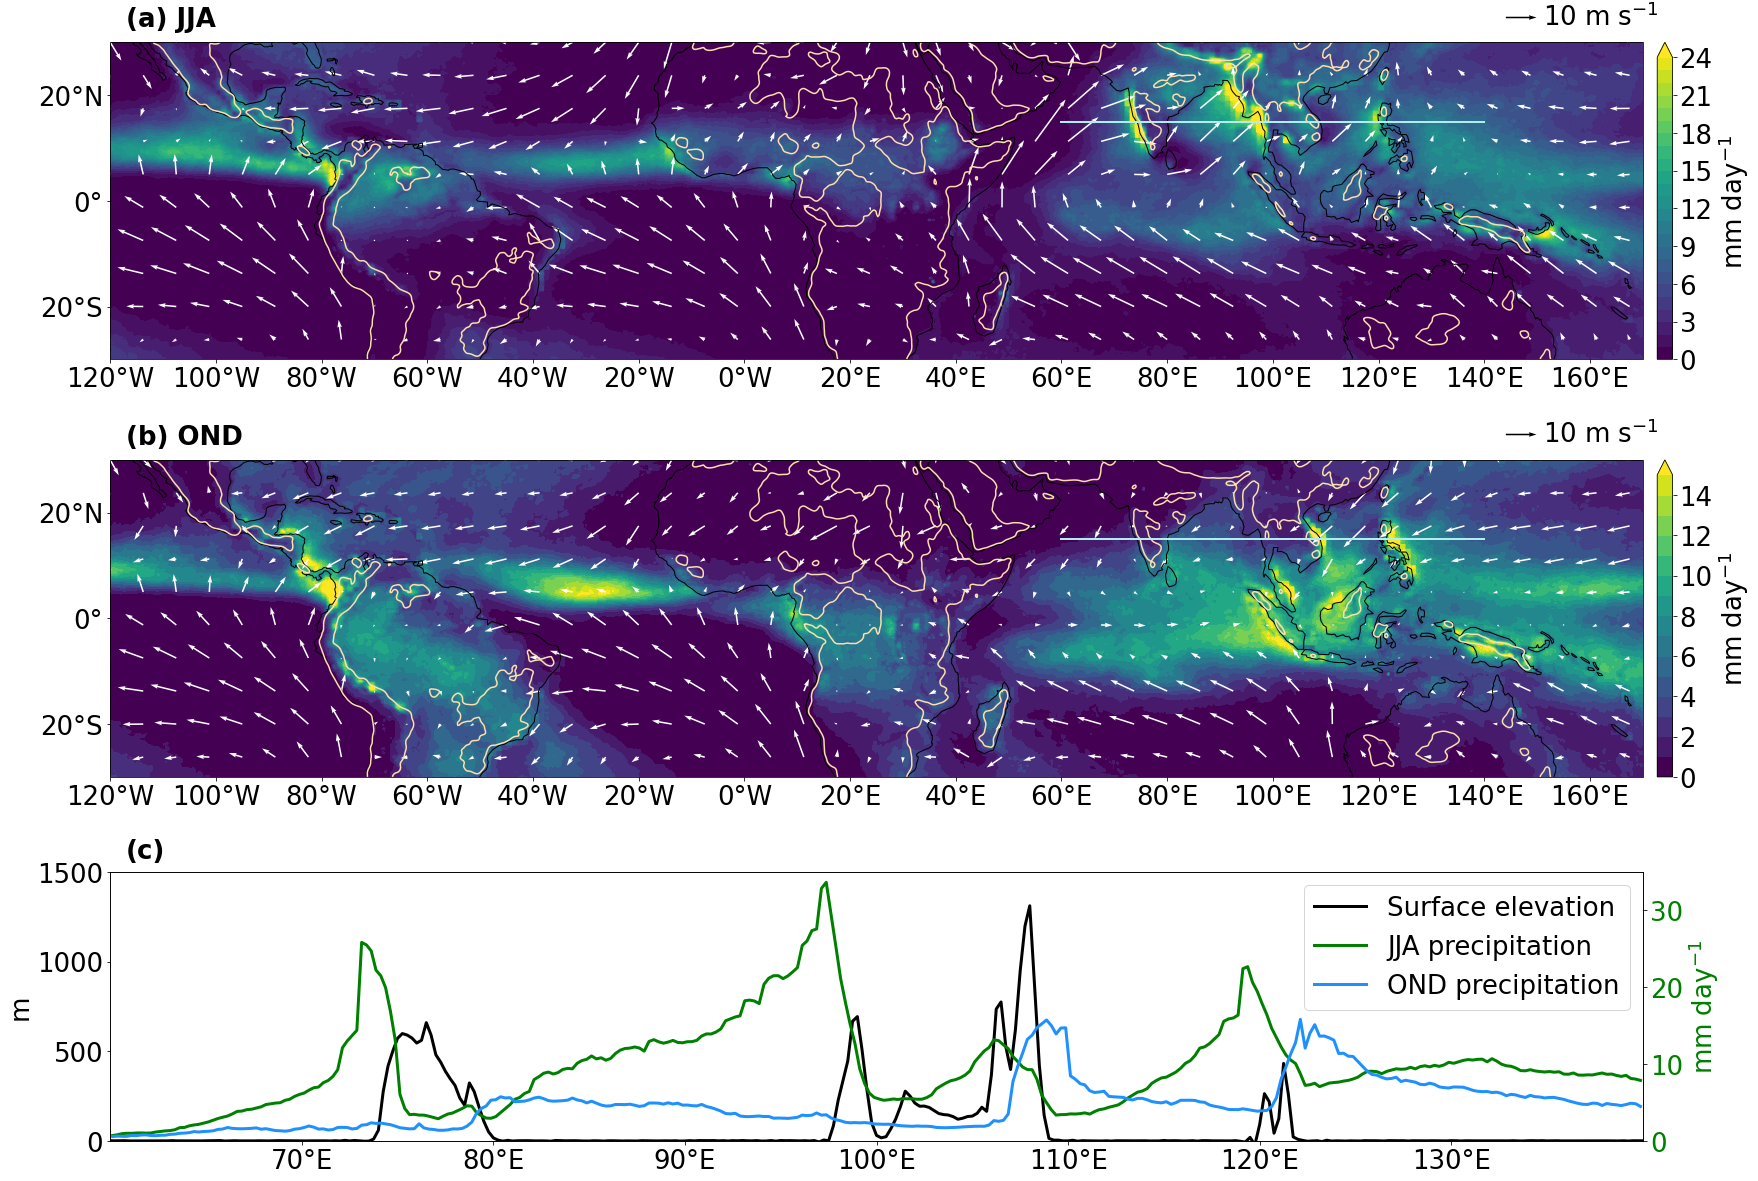

In [117]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(25,17))
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios= [5,5,4.1],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax1 = fig.add_subplot(spec[1],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[2])

cf = pr_trmm_plot_jja.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,25.,1.),add_colorbar=False)#,cbar_kwargs={'label':r'mm day$^{-1}$'}
cf1=pr_trmm_plot_ond.sel(longitude=slice(-120,170)).plot.contourf(ax=ax1,levels=np.arange(0.,16.,1.),add_colorbar=False)#,cbar_kwargs={'label':r'mm day$^{-1}$'}

for a,c,uplot,vplot in (ax,cf,u100plot_jja,v100plot_jja),(ax1,cf1,u100plot_ond,v100plot_ond):
    orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='navajowhite',linewidths=[1.5])
    
    u=uplot.sel(longitude=slice(-120,170))
    v=vplot.sel(longitude=slice(-120,170))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=25
    m=n
    Q = a.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=500)

    
    a.plot([60,140],[15,15],color='paleturquoise',linewidth=2)
    a.coastlines()
    a.set_ylim(-30,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    a.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
    pad=.2;size="1%"
    
    divider = make_axes_locatable(a)
    cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$')

    qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                       coordinates='axes',color='k')
ax.text(0.01, 1.05,'(a) JJA', transform=ax.transAxes,color='k',weight='bold')
ax1.text(0.01, 1.05,'(b) OND', transform=ax1.transAxes,color='k',weight='bold')
#rw=0.15
#ax.add_patch(plt.Rectangle((0,1-rw), rw/5, rw, fc='w',ec='w',transform=ax.transAxes,zorder=2))
#ax.text(0.001, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')


ax3=cross_section(60,140,15,ax2)
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel(r'mm day$^{-1}$',color='g')
ax3.text(0.01, 1.05,'(c)', transform=ax3.transAxes,color='k',weight='bold')

fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/trmmOrog.png', dpi=300 ,bbox_inches='tight')

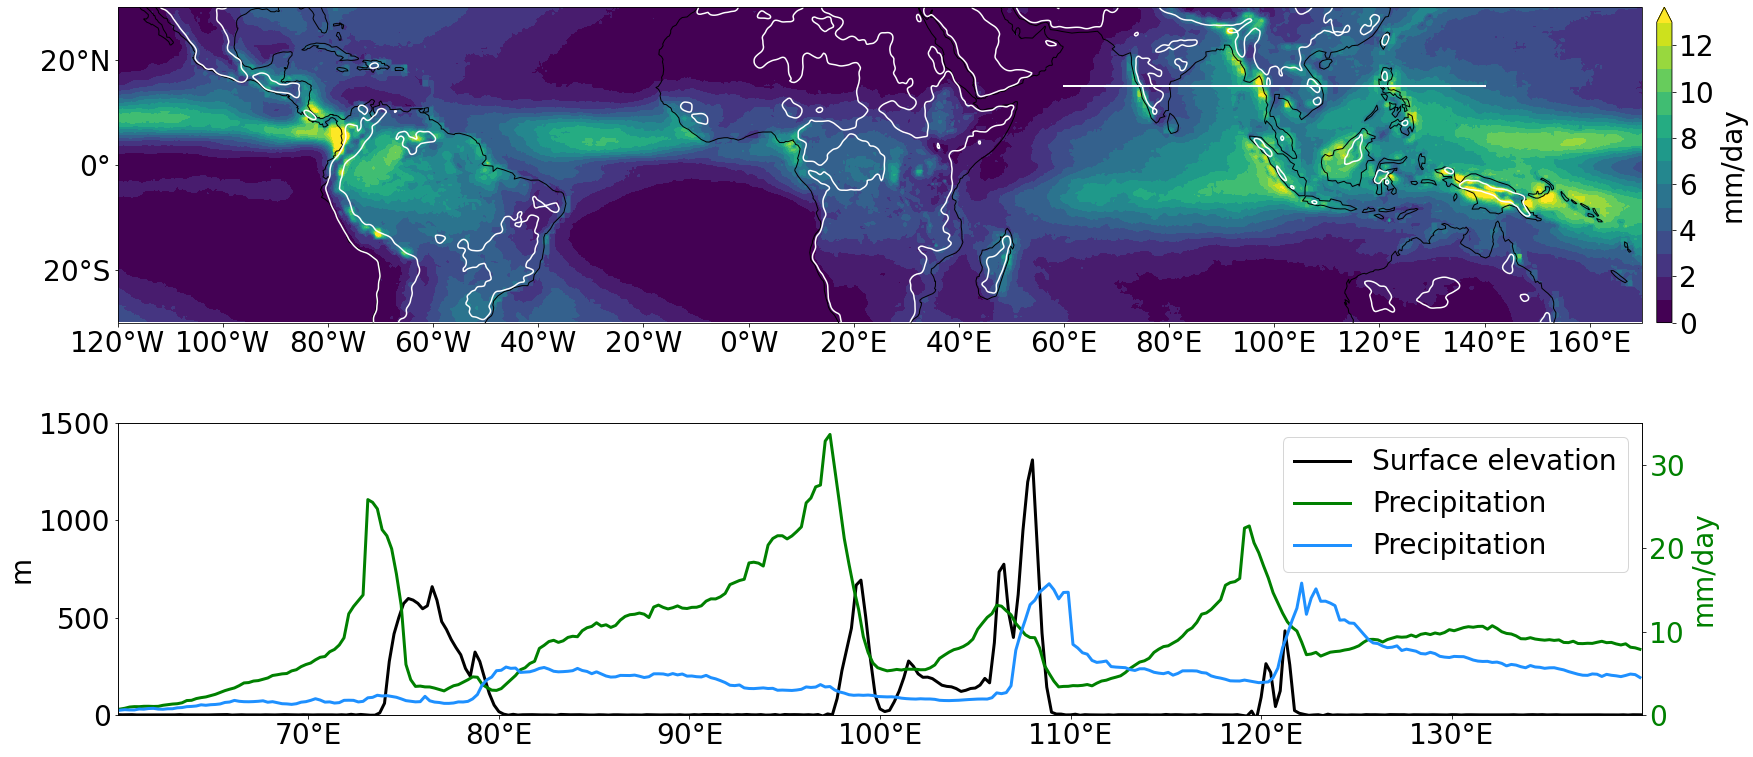

In [408]:
matplotlib.rcParams.update({'font.size': 28})
fig = plt.figure(figsize=(25,12))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3, 2],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[1])

cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#,cbar_kwargs={'label':r'mm day$^{-1}$'}
orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1.5])
ax.plot([60,140],[15,15],color='w',linewidth=2)

ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label=r'mm day$^{-1}$')

ax3=cross_section(60,140,15,ax2)
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel("mm/day",color='g')
fig.tight_layout()

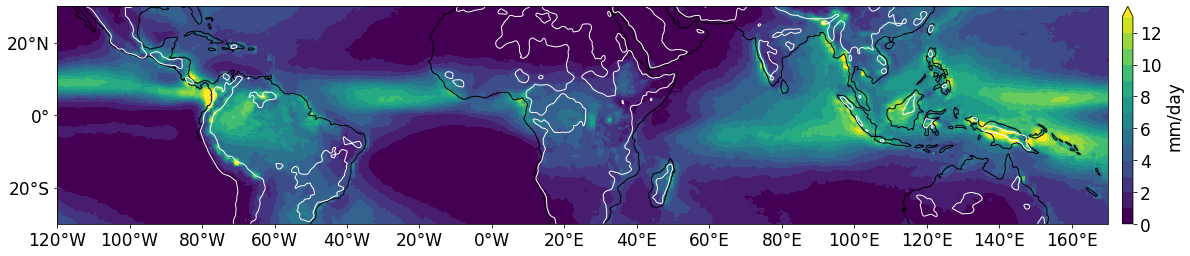

In [16]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label=r'mm day$^{-1}$')

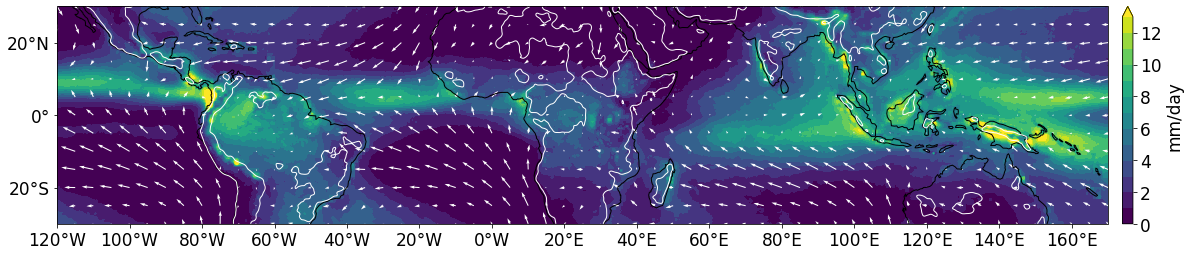

In [20]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

u=u100plot.sel(longitude=slice(-120,170)).mean('month')
v=v100plot.sel(longitude=slice(-120,170)).mean('month')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=20
m=n
ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=600)



ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label=r'mm day$^{-1}$')

# Figure 2 - Theory precip

In [313]:
np.sqrt(9.81/300 * 3e-3)

0.009904544411531506

In [12]:
from scipy.integrate import cumtrapz
from scipy.special import expi

def k_vector(Nx,dx):
    return 2*np.pi*np.fft.fftfreq(Nx,dx)

def m_exponent(k,N,U):
    return - np.sign(k**2-N**2/U**2)**((np.sign(k+1e-4*k[1])+1)/2) * np.sqrt(k**2-N**2/U**2+0.j) #1e-4*k[1] it there to avoid fractional powers

#def linear_mountain_wave(h,N,U,x,z):
#    k=k_vector(len(x),x[1]-x[0])
#    h_hat = np.fft.fft(h)
#    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
#    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
#    return w

def linear_p_theory(u,kind='gaussian',a=100e3,A=1000,tauT=3,tauq=11,switch=1,P0 = 4.):
    xx=np.arange(-10000e3,20000e3,5e3)
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    elif kind=='agnesi':
        hx = A*a**2/(xx**2+a**2)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    
    Lq=5*u*tauqtilde
    
    zbot=1000
    ztop=3000
    
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    chi = 8000 * (ds0dz/tauT - dq0dz/tauq)/ 2.5e6 * 86400
    N=np.sqrt(9.81/300 * ds0dz/1004.)
    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + switch*1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,u)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return xx,hx,P

def analytical_P_agnesi(u,a=100e3,A=1000,tauT=3,tauq=11,switch=1):
    xx=np.arange(-10000e3,20000e3,5e3)
    P0 = 4. # mm/day
    
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    Lq=5*u*tauqtilde
    
    zbot=1000
    ztop=3000
    
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    chi = 8000 * (ds0dz/tauT - dq0dz/tauq)/ 2.5e6 * 86400

    N=np.sqrt(9.81/300 * ds0dz/1004.)
    l=N/u
    cosfact=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)
    sinfact=(np.sin(l*ztop)-np.sin(l*zbot))/(l*ztop-l*zbot)

    #P = P0 - chi*A*a*xx/(xx**2+a**2) * cosfact
    #P = P0 - chi*A*a/xx * cosfact
    P = P0 + chi * cosfact * A*a *(-xx/(xx**2+a**2)+switch*1/Lq*np.exp(-xx/Lq)*expi(xx/Lq)) + chi * sinfact * A*a**2/(xx**2+a**2)
    P = np.maximum(0.,P)
    return xx,P


In [467]:
x[np.where(P1000>5)[0][0]]

-1705.0

In [468]:
x[np.where(P500>5)[0][0]]

-1055.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


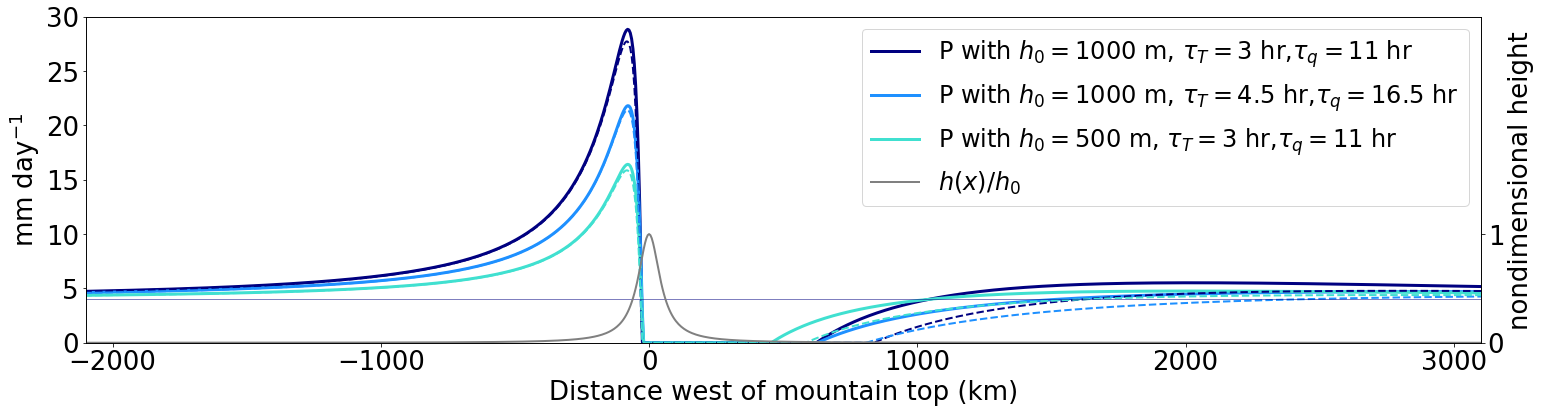

In [125]:
matplotlib.rcParams.update({'font.size': 26})
x,hx,P1000 = linear_p_theory(10,kind='agnesi',a=50e3,A=1000)
_,_,P500  = linear_p_theory(10,kind='agnesi',a=50e3,A=500)
_,_,Ptau  = linear_p_theory(10,kind='agnesi',a=50e3,A=1000,tauT=4.5,tauq=16.5)
_,P1000a = analytical_P_agnesi(10,a=50e3,A=1000)
_,P500a  = analytical_P_agnesi(10,a=50e3,A=500)
_,Ptaua  = analytical_P_agnesi(10,a=50e3,A=1000,tauT=4.5,tauq=16.5)

#x,hx1,P1000a = linear_p_theory(10,kind='cos',a=100e3,A=1000)
#x,hx2,P500a = linear_p_theory(10,kind='gaussian',a=100e3,A=1000)


x/=1000

fig,ax=plt.subplots(1,1,figsize=(25,6))
ax2=ax.twinx()

# precips
ax.plot(x,P1000,label=r"P with $h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr",color='navy',linewidth=3)
ax.plot(x,Ptau,label=r"P with $h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr",color='dodgerblue',linewidth=3)
ax.plot(x,P500,label=r"P with $h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr",color='turquoise',linewidth=3)


ax.plot(x,P1000a,linestyle='--',color='navy',linewidth=2)
ax.plot(x,Ptaua ,linestyle='--',color='dodgerblue',linewidth=2)
ax.plot(x,P500a ,linestyle='--',color='turquoise',linewidth=2)

# mountain
ax2.plot(x,hx/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)
#ax2.plot(x,hx1/1000,label=r"$h(x)/h_0$",color='k',linewidth=3)
#ax2.plot(x,hx2/1000,label=r"$h(x)/h_0$",color='k',linewidth=3)


ax.axhline(4.,linewidth=0.5,color='navy')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,3.1e3)
ax.set_ylim(0,30)

ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,3)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/analyticalAgnesi.eps',bbox_inches='tight')

## additional

In [311]:
0.6*11*3600*5*10/1000

1188.0

In [461]:
def analytical_max(u,a=100e3,A=1000,tauT=3,tauq=11):
    P0 = 4. # mm/day
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    Lq=u*5*tauqtilde
    
    zbot=1000
    ztop=3000
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    chi = 8000 * (ds0dz/tauT - dq0dz/tauq)/ 2.5e6 * 86400
    N=np.sqrt(9.81/300 * ds0dz/1004.)
    l=N/u
    cosfact=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)
    sinfact=(np.sin(l*ztop)-np.sin(l*zbot))/(l*ztop-l*zbot)
    
    print(cosfact*chi*A)

    xm = -a*(np.sqrt(1+(sinfact/cosfact)**2)-sinfact/cosfact)
    return P0 + chi * cosfact * A*a *(1/(-2*xm)+1/Lq*np.exp(-xm/Lq)*expi(xm/Lq))
    
    #return P0 + chi * cosfact * A*a *(-xm/(xm**2+a**2)+1/Lq*np.exp(-xm/Lq)*expi(xm/Lq)) + chi * sinfact * A*a**2/(xm**2+a**2)
    #return P0+chi*cosfact*(A/2 + A*a/Lq*np.exp(a/Lq)*(np.log(a/Lq)+0.57)) + chi * sinfact * A/2

In [462]:
As = np.arange(100,1100,100)
an=[]
tr=[]
for A in As:
    _,_,P=linear_p_theory(10,kind='agnesi',a=50e3,A=A)
    tr.append(max(P))
    an.append(analytical_max(10,a=50e3,A=A))

10.36077276475131
20.72154552950262
31.082318294253934
41.44309105900524
51.80386382375656
62.16463658850787
72.52540935325918
82.88618211801048
93.2469548827618
103.60772764751312


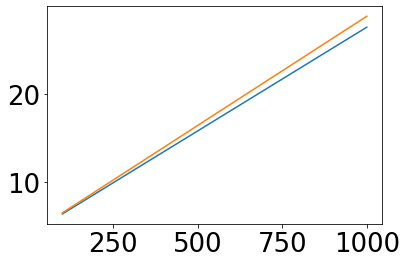

In [448]:
plt.plot(As,an)
plt.plot(As,tr)

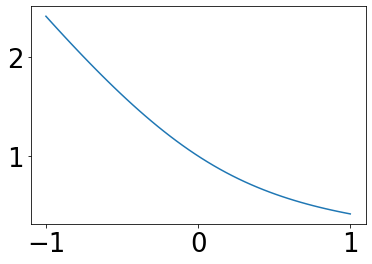

In [433]:
x=np.linspace(-1.,1.)
plt.plot(x,np.sqrt(1+x**2)-x)

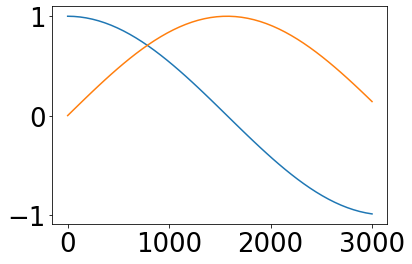

In [435]:
z=np.linspace(0,3000)
plt.plot(z,np.cos(1e-3*z))
plt.plot(z,np.sin(1e-3*z))

In [426]:
aas = np.arange(20e3,110e3,10e3)
an=[]
tr=[]
for a in aas:
    _,_,P=linear_p_theory(10,kind='agnesi',a=a,A=1000)
    tr.append(max(P))
    an.append(analytical_max(10,a=a,A=1000))

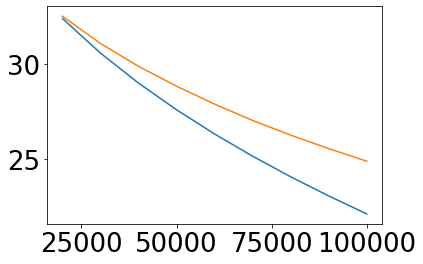

In [427]:
plt.plot(aas,an)
plt.plot(aas,tr)

In [249]:
def analytical_upsextent(u,a=100e3,A=1000,tauT=3,tauq=11):
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    Lq=u*5*tauqtilde
    
    zbot=1000
    ztop=2500
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    chi = 8000 * (ds0dz/tauT - dq0dz/tauq)/ 2.5e6 * 86400
    N=np.sqrt(9.81/300 * ds0dz/1004.)
    l=N/u
    cosfact=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)
    
    return -chi*cosfact*a*A


In [250]:
As = np.arange(100,1100,100)
an=[]
tr=[]
for A in As:
    xx,_,P=linear_p_theory(10,kind='agnesi',a=50e3,A=A)
    tr.append(xx[np.where(P>5)[0][0]])
    an.append(analytical_upsextent(10,a=50e3,A=A))

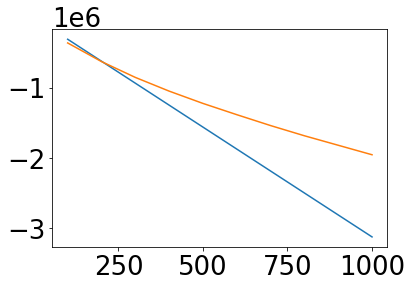

In [253]:
plt.plot(As,np.array(an)/2)
plt.plot(As,tr)

In [284]:
aas = np.arange(20e3,110e3,10e3)
an=[]
tr=[]
for a in aas:
    _,_,P=linear_p_theory(10,kind='agnesi',a=a,A=1000)
    tr.append(xx[np.where(P>5)[0][0]])
    an.append(analytical_upsextent(10,a=a,A=1000))


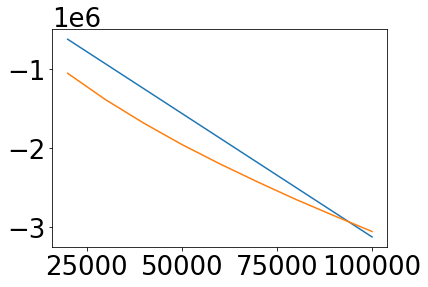

In [286]:
plt.plot(aas,np.array(an)/4)
plt.plot(aas,tr)

In [279]:
us = np.arange(8,30,1)
tr=[]
for u in us:
    xx,_,P=linear_p_theory(u,kind='agnesi',a=50e3,A=1000)
    tr.append(xx[np.where(P<4*(1-np.exp(-1)))[0][-1]])

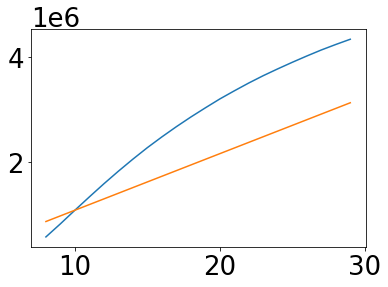

In [280]:
plt.plot(us,tr)
plt.plot(us,us*5*6*3600)

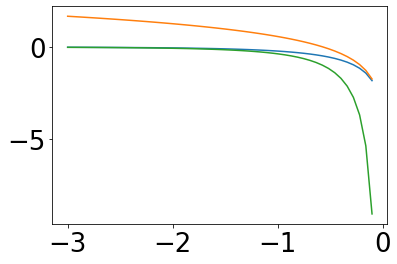

In [256]:
x=np.linspace(-3,-0.1)
plt.plot(x,expi(x))
plt.plot(x,0.57+np.log(-x))
plt.plot(x,np.exp(x)/x)

# Figure 3 - WRF Precip & CAPE

In [14]:
hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()
hrcape=hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['Time','south_north']).load()

In [15]:
lmpr=lmchannelprecip.isel(Time=slice(200,1201)).mean(['Time','south_north']).load()
lmcape=lmchannel_capecin[0].isel(Time=slice(200,1201)).mean(['Time','south_north']).load()

In [16]:
%%time
hrpr_intervals   = np.zeros((15,len(hrchannel.west_east)))
hrcape_intervals = np.zeros((15,len(hrchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    hrpr_intervals[i]=np.array(hrchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    hrcape_intervals[i]=np.array(hrchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())

CPU times: user 1.65 s, sys: 1.81 s, total: 3.46 s
Wall time: 3.4 s


In [17]:
%%time
lmpr_intervals   = np.zeros((20,len(lmchannel.west_east)))
lmcape_intervals = np.zeros((20,len(lmchannel.west_east)))
for i,t in enumerate(range(200,1000,40)):
    lmpr_intervals[i]=np.array(lmchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    lmcape_intervals[i]=np.array(lmchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())

CPU times: user 2.28 s, sys: 2.23 s, total: 4.51 s
Wall time: 4.45 s


(0.0, 25.0)

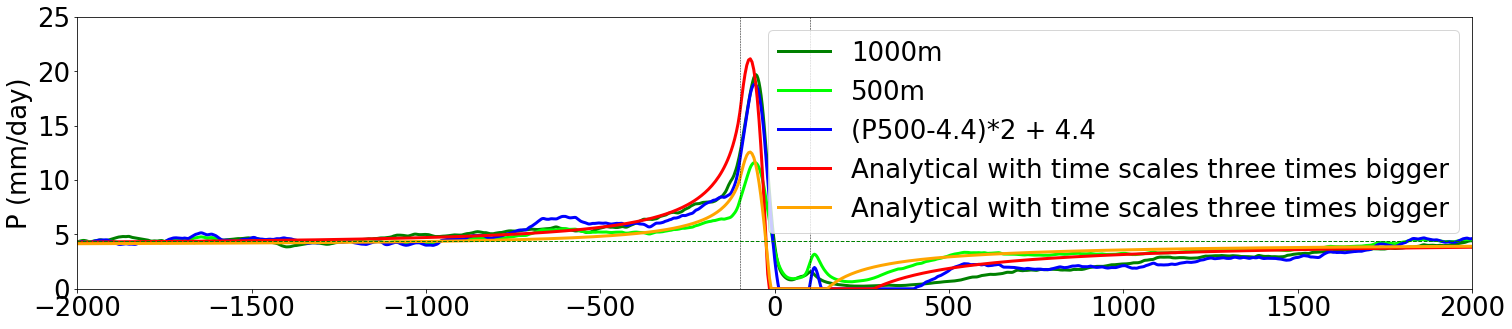

In [486]:
matplotlib.rcParams.update({'font.size': 26})

_,axpr=plt.subplots(1,1,figsize=(25,5))

axpr.plot(hrdist,hrpr,label="1000m",color='g',linewidth=3)
axpr.plot(hrdist,lmpr,label="500m",color='lime',linewidth=3)

axpr.plot(hrdist,np.maximum(0.,2*(lmpr-4.4)+4.4),label="(P500-4.4)*2 + 4.4",color='b',linewidth=3)

alpha=3.
x,hx,Ptau  = linear_p_theory(10,kind='cos',a=100e3,A=1000,tauT=3.*alpha,tauq=11*alpha)
axpr.plot(x/1000,Ptau,label="Analytical with time scales three times bigger",color='r',linewidth=3)
x,hx,Ptau  = linear_p_theory(10,kind='cos',a=100e3,A=500,tauT=3.*alpha,tauq=11*alpha)
axpr.plot(x/1000,Ptau,label="Analytical with time scales three times bigger",color='orange',linewidth=3)


axpr.axvline(- 100,color='k', linestyle='--',linewidth=0.5)
axpr.axvline(  100,color='k', linestyle='--',linewidth=0.5)
axpr.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

axpr.legend()

axpr.set_xlim(-2000,2000)
axpr.set_ylabel(r'P (mm day$^{-1}$)')
axpr.set_ylim(0,25)

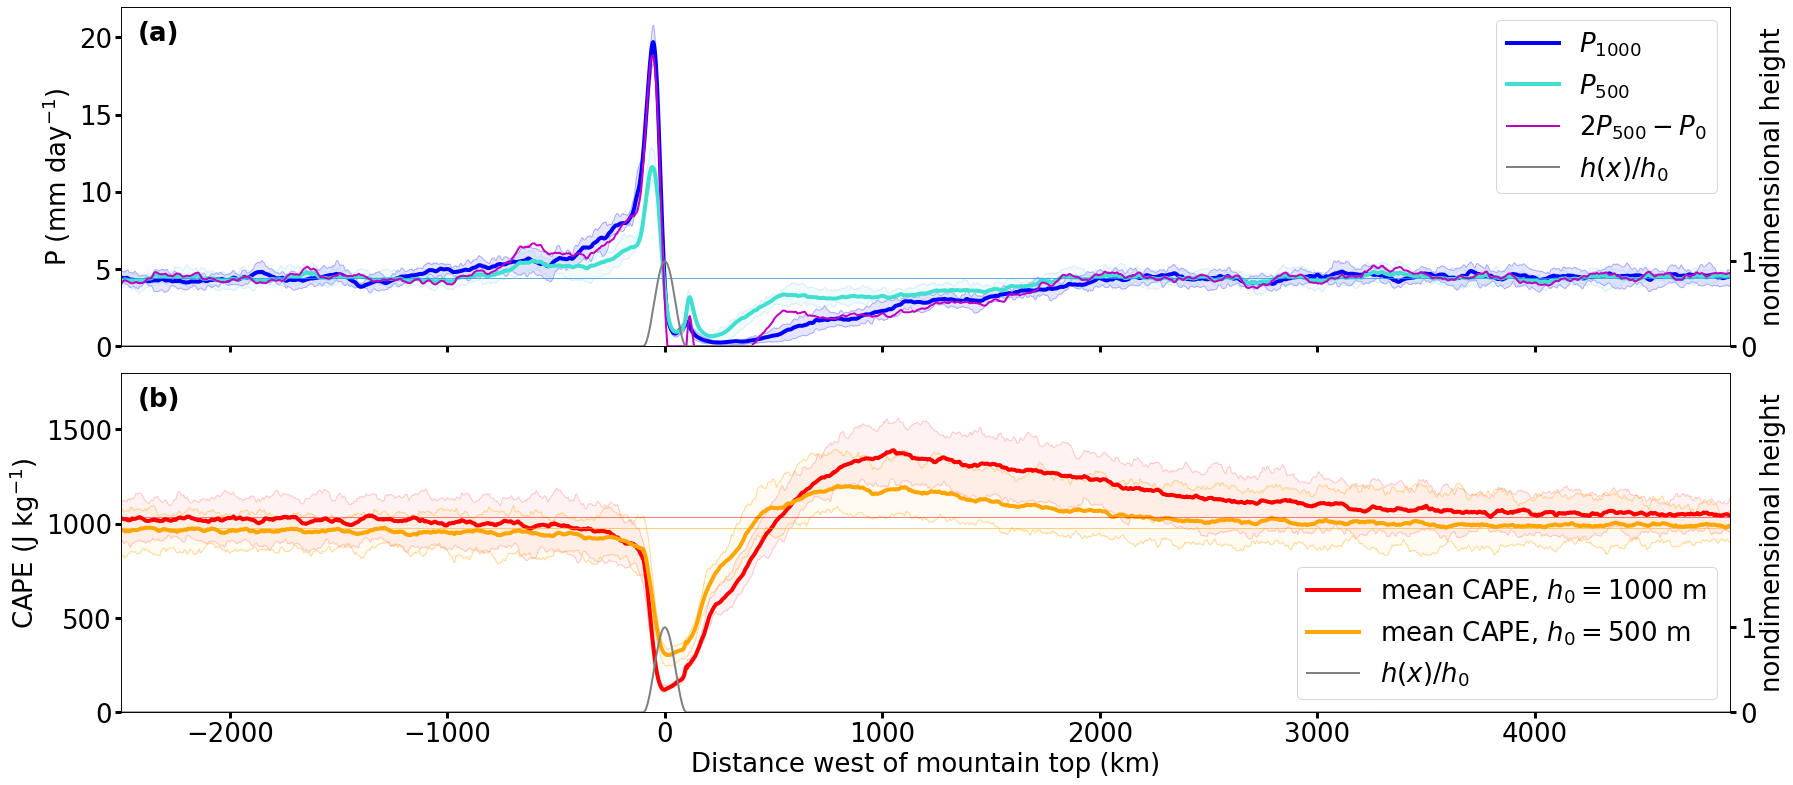

In [123]:
matplotlib.rcParams.update({'font.size': 26})

fig,(axpr,axca)=plt.subplots(2,1,figsize=(25,11))
axmt1=axpr.twinx()
axmt2=axca.twinx()

lw=2
lw2=4
falpha=0.1
ealpha=0.3

#PANEL 1 - Precip
axpr.plot(hrdist,hrpr,label=r"$P_{1000}$",color='b',linewidth=lw2)
axpr.plot(hrdist,lmpr,label=r"$P_{500}$",color='turquoise',linewidth=lw2)
axpr.fill_between(hrdist,np.percentile(hrpr_intervals,25,axis=0),np.percentile(hrpr_intervals,75,axis=0),facecolor=(0,0,1,falpha), edgecolor=(0,0,1,ealpha))
axpr.fill_between(hrdist,np.percentile(lmpr_intervals,25,axis=0),np.percentile(lmpr_intervals,75,axis=0),facecolor=(*to_rgb('skyblue'),falpha), edgecolor=(*to_rgb('skyblue'),ealpha))
axpr.axhline(hrpr[2000:3000].mean(),color='b',linestyle='-',linewidth=.5)
axpr.axhline(lmpr[2000:3000].mean(),color='turquoise',linestyle='-',linewidth=.5)
axpr.plot(hrdist,np.maximum(0.,2*(lmpr-4.4)+4.4),label=r"$2P_{500}-P_0$",color='m',linewidth=lw)


axpr.set_ylim(0,22)
axpr.set_ylabel(r'P (mm day$^{-1}$)')


#PANEL 2 - CAPE

axca.plot(hrdist,hrcape,label=r"mean CAPE, $h_0=1000$ m",color='r',linewidth=lw2)
axca.plot(hrdist,lmcape,label=r"mean CAPE, $h_0=500$ m",color='orange',linewidth=lw2)
falpha=0.05;ealpha=0.2
axca.fill_between(hrdist,np.percentile(hrcape_intervals,25,axis=0),np.percentile(hrcape_intervals,75,axis=0),facecolor=(1.,0,0,falpha), edgecolor=(1.,0,0,ealpha))
falpha=0.05;ealpha=0.4
axca.fill_between(hrdist,np.percentile(lmcape_intervals,25,axis=0),np.percentile(lmcape_intervals,75,axis=0),facecolor=(*to_rgb('orange'),falpha), edgecolor=(*to_rgb('orange'),ealpha))
axca.axhline(hrcape[2000:3000].mean(),color='r',linestyle='-',linewidth=0.5)
axca.axhline(lmcape[2000:3000].mean(),color='orange',linestyle='-',linewidth=0.5)

axca.set_ylim(0,1800)
axca.set_xlabel("Distance west of mountain top (km)")
axca.set_ylabel(r"CAPE (J kg$^{-1}$)")

#Mountains & decoration
for a,am,loc,txt in ((axpr,axmt1,0,'(a)'),(axca,axmt2,4,'(b)')):
    am.plot(hrdist,hrhgt/1000,color='gray',label=r'$h(x)/h_0$',linewidth=2)
    am.set_xlim(-2500,4900)
    am.set_ylim(0,4)
    am.set_ylabel('nondimensional height')
    am.set_yticks([0,1])
    
    lines,labels = a.get_legend_handles_labels()
    lines2,labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=loc)
    a.text(0.01, 0.9,txt, transform=a.transAxes,color='k',weight='bold')

    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if txt!='(b)':
        ticks=range(-2000,5000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))

fig.tight_layout(pad=0.4)
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wrfPCape.png', dpi=300 ,bbox_inches='tight')

# Figure 4 - x-z cross sections of vertical motion, from moist & dry simulations

In [21]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wdrymean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)

wmean_p = interp_eta_to_pressure(hrchannel,wmean_s)
wdrymean_p = interp_eta_to_pressure(hrchannel,wdrymean_s)

In [ ]:
wmean_p[:,1730].plot(y='pressure',yincrease=False)
wdrymean_p[:,1730].plot(y='pressure',yincrease=False)

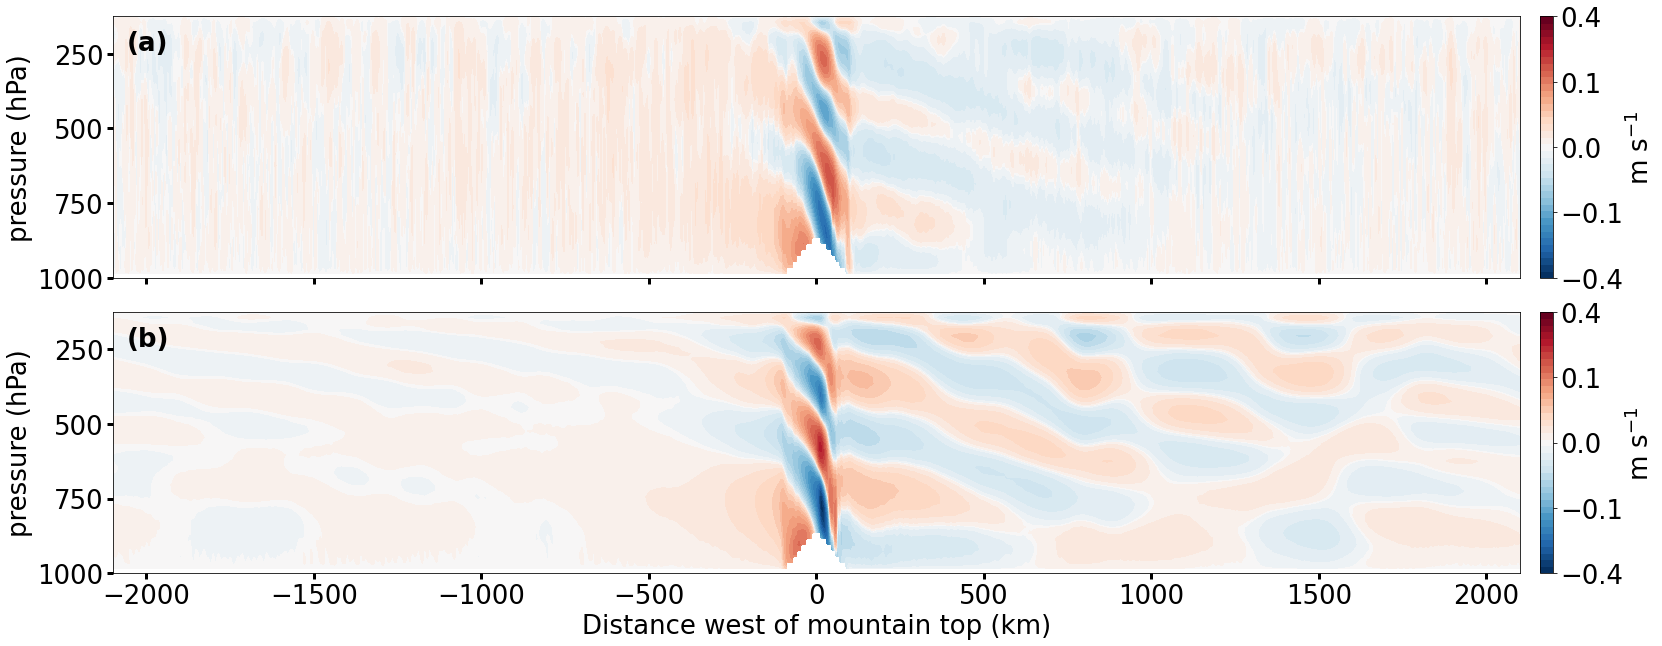

In [131]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

wmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
wdrymean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wxz.png', dpi=300 ,bbox_inches='tight')


In [73]:
umean_s = change_coords_eta(hrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc'),1,meta=True),staggered=False)
umean_p = interp_eta_to_pressure(hrchannel,umean_s,staggered=False)

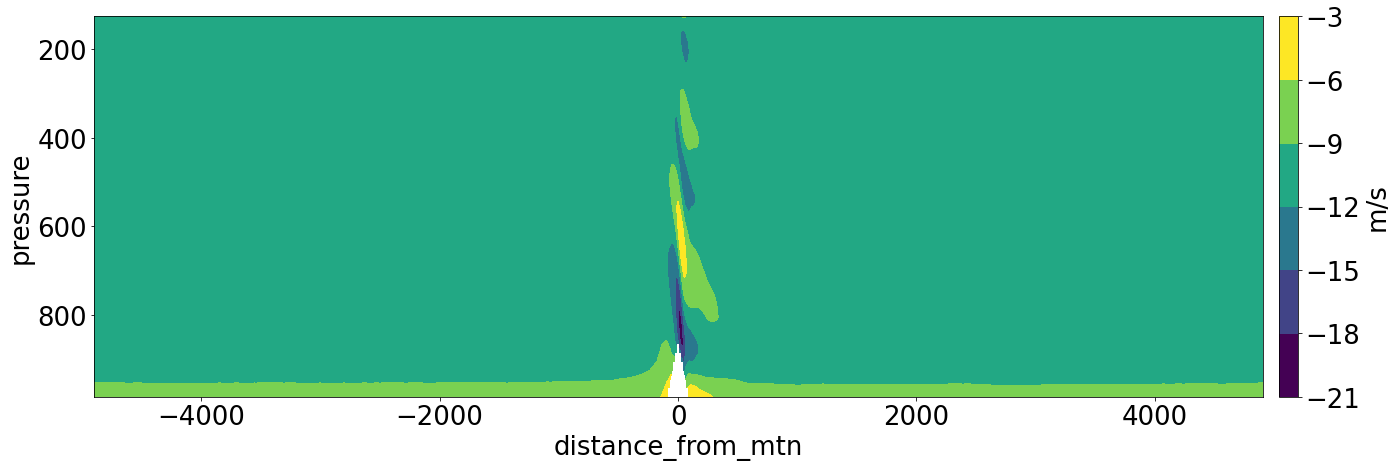

In [75]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

umean_p.plot.contourf(ax=ax,yincrease=False,cbar_kwargs={'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)


# Figure 5 - x-y cross section of vertical motion at 500hPa

In [213]:
#%%time
#def change_coords_sn(var):
#    return var.assign_coords({'distance_ns':3*var.south_north}).swap_dims({'south_north':'distance_ns'})
#
#ndays=1
#w_day152 = change_coords_sn(change_coords_pl(hrchannel_p,hrchannel_p.W_PL.isel(Time=slice(3648,3648+ndays*24)).squeeze())).sel(distance_from_mtn=slice(400,-400))
#w_day152=w_day152.where(w_day152>-100).fillna(0.)
#w_day152=w_day152.sel(pressure=500.).persist()
#w_day152.to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

CPU times: user 0 ns, sys: 11min 22s, total: 11min 22s
Wall time: 12min 50s


In [23]:
w_day152=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

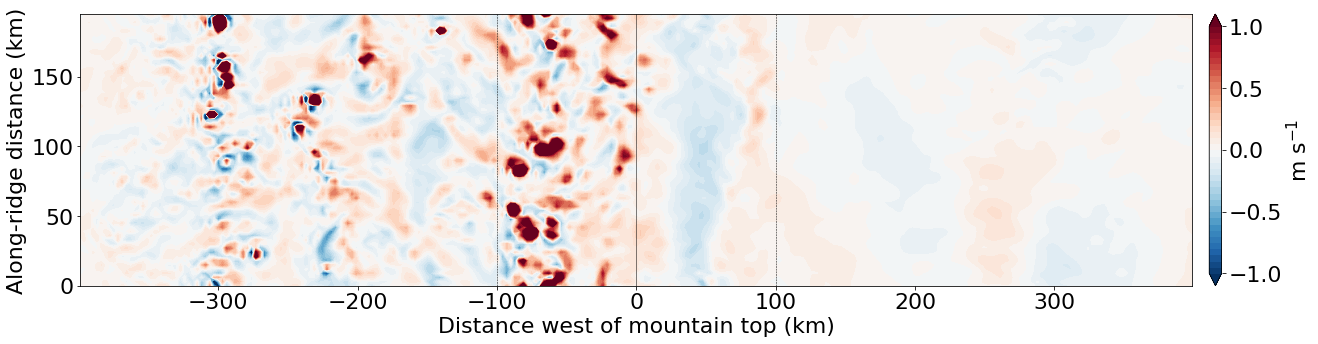

In [56]:
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(1,1,figsize=(25,5))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)
i=19

ax.axvline(   0.,color='k',linewidth=0.5)
ax.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
ax.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
w_day152.isel(Time=i).plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':r'm s$^{-1}$','pad':.012})
ax.set_aspect("equal")
ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("Along-ridge distance (km)")
ax.set_title("")
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wxy.eps',bbox_inches='tight')

# Figure 6 - Thermo equation breakdown

In [31]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')

umean = umean.where(umean >-30.)  
wmean   = wmean.where(wmean > -10)  
rhomean = rhomean.where(rhomean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean

umean_p = change_coords_pl(hrchannel_p,umean)[5:-7]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[5:-7]
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[5:-7]
thetamean_p = (tmean_p*(tmean_p.pressure/1e3)**(-0.286))

In [32]:
dryumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.days50-100.nc')[::-1]
drywmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.days50-100.nc')[::-1]
dryrhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.days50-100.nc')[::-1]
drytmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.days50-100.nc')[::-1]

dryumean     = dryumean.where(dryumean >-30.)  
drywmean     = drywmean.where(drywmean > -10)  
dryrhomean   = dryrhomean.where(dryrhomean >0.)  
drytmean     = drytmean.where(drytmean >100.)  
dryomegamean = -9.81*dryrhomean*drywmean

dryumean_p     = change_coords_sfc(dryumean)[4:-3]
drytmean_p     = change_coords_sfc(drytmean)[4:-3]
dryomegamean_p = change_coords_sfc(dryomegamean)[4:-3]
drythetamean_p = (drytmean_p*(drytmean_p.pressure/1e3)**(-0.286))

In [33]:
plevs_875 = np.array(umean_p.pressure[::-1])
DeltaP=250-875

In [34]:
%%time
Qrad = hrchannel.RTHRATEN.sel(Time=slice(200,300)).mean(['Time','south_north'])*86400
Qrad_p = interp_eta_to_pressure(hrchannel,change_coords_eta(hrchannel,Qrad),staggered=0,plevs=plevs_875)
Qrad_p = Qrad_p.integrate('pressure')/DeltaP

CPU times: user 4.68 s, sys: 8.92 s, total: 13.6 s
Wall time: 35.7 s


In [35]:
pi = (drytmean_p.pressure/1e3)**0.286
dryudtdx_p = -(dryumean_p*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegadsdp_p = (pi*dryomegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udtdx_p = -(umean_p*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadsdp_p = (pi*omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_p = udtdx_p+omegadsdp_p- Qrad_p

In [36]:
dryu0dtdx_p = -(-10*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegads0dp_p = (pi*dryomegamean_p*drythetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

u0dtdx_p = -(-10*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegads0dp_p = (pi*omegamean_p*thetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_p_lin = u0dtdx_p+omegads0dp_p- Qrad_p

In [37]:
hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()
hrpr_K = 2.5e6/1004./(-DeltaP*100)*9.81*hrpr

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


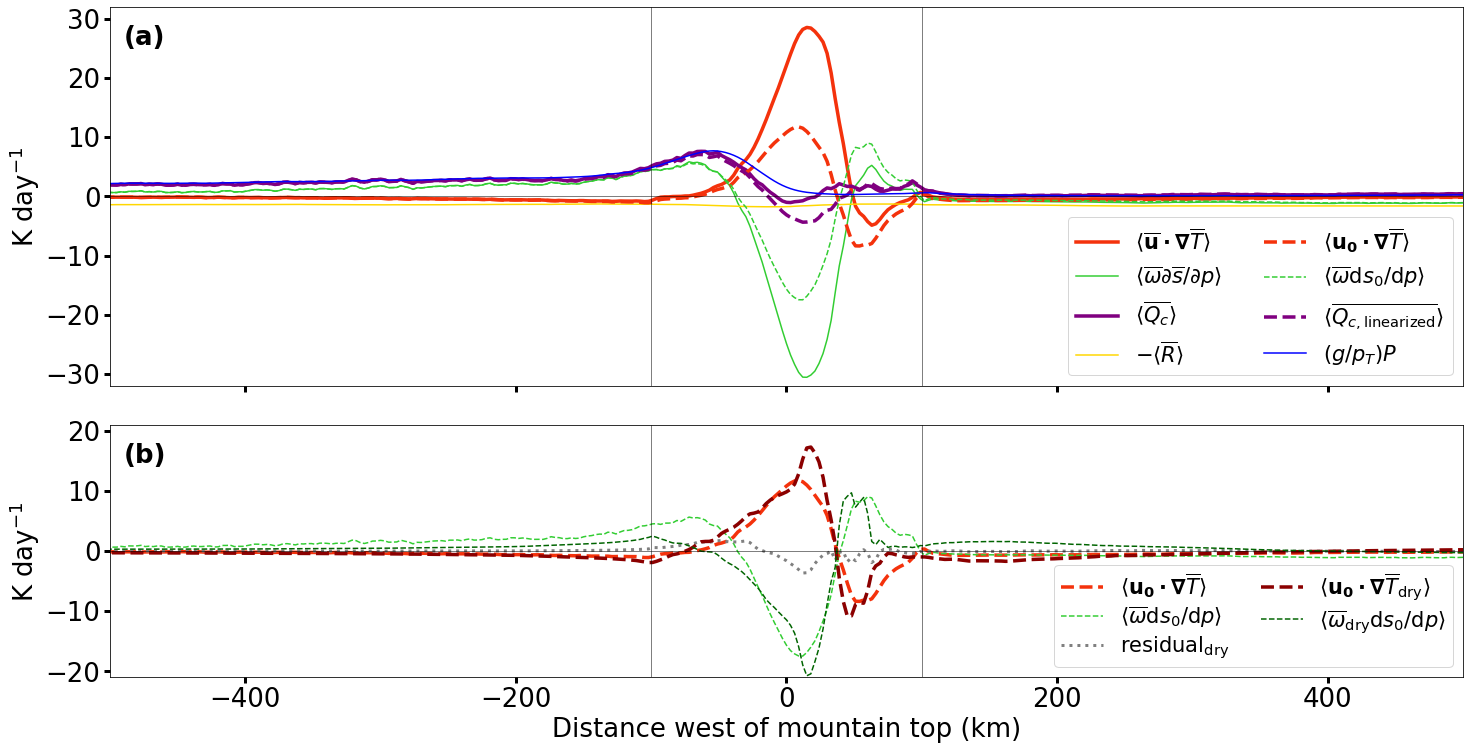

In [134]:
matplotlib.rcParams.update({'font.size': 26})

fig = plt.figure(figsize=(21,11))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,2],figure=fig)
ax  = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
lw1=3.5
lw2=1.5

ax.plot(hrdist, udtdx_p     ,linewidth=lw1,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion",linestyle='-')
ax.plot(hrdist, omegadsdp_p ,linewidth=lw2,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen"          ,linestyle='-')
ax.plot(hrdist, Qdiab_p     ,linewidth=lw1,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple"        ,linestyle='-')
ax.plot(hrdist, Qrad_p      ,linewidth=lw2,label=r"$-\langle \overline{R}                                    \rangle$", color='gold'        )

ax.plot(hrdist, u0dtdx_p    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}     \rangle$",color="xkcd:vermillion",linestyle='--')
ax.plot(hrdist, omegads0dp_p,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="limegreen"      ,linestyle='--')
ax.plot(hrdist, Qdiab_p_lin ,linewidth=lw1,label=r"$\langle\overline{Q_{c,\mathrm{linearized}}}        \rangle$",color="purple"         ,linestyle='--')
ax.plot(hrdist, hrpr_K      ,linewidth=lw2,label=r"$(g/p_T)P$", color='b')



#ax2.plot(hrdist, udtdx_p       ,linewidth=lw1,label=r"$\langle\mathbf{u \cdot \nabla } \overline{T}    \rangle$",color="xkcd:vermillion" ,linestyle='-')
#ax2.plot(hrdist, omegadsdp_p   ,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s/\mathrm{d}p\rangle$",color="limegreen"       ,linestyle='-')
ax2.plot(hrdist, u0dtdx_p      ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}    \rangle$",color="xkcd:vermillion",linestyle='--')
ax2.plot(hrdist, omegads0dp_p  ,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p\rangle$",color="limegreen"      ,linestyle='--')
ax2.plot(hrdist, dryu0dtdx_p +dryomegads0dp_p   ,linewidth=3,label=r"residual$_\mathrm{dry}$",color="grey" ,linestyle=':')

#ax2.plot(hrdist, dryudtdx_p     ,linewidth=lw1,label=r"$\langle\mathbf{u \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="darkred" ,linestyle='-')
#ax2.plot(hrdist, dryomegadsdp_p ,linewidth=lw2,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s/\mathrm{d}p \rangle$",color="darkgreen"   ,linestyle='-')
ax2.plot(hrdist, dryu0dtdx_p    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="darkred" ,linestyle='--')
ax2.plot(hrdist, dryomegads0dp_p,linewidth=lw2,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="darkgreen"   ,linestyle='--')


#ax2.plot(hrdist, u0dtdx_p-dryu0dtdx_p         ,linewidth=3,label=r"$\mathbf{u_0 \cdot \nabla } (\overline{T}-\overline{T}_{\mathrm{dry}})$"     ,color="xkcd:vermillion")
##ax2.plot(hrdist, omegads0dp_p-dryomegads0dp_p ,linewidth=3,label=r"$(\overline{\omega}-\overline{\omega}_{\mathrm{dry}}) \mathrm{d}s_0/\mathrm{d}p $",color="green")
#ax2.plot(hrdist, omegads0dp_p-dryomegads0dp_p-Qrad_p,linewidth=3,label=r"$\overline{Q_\mathrm{diab,moist}}$", color="magenta")
#ax2.plot(hrdist, hrpr_K,linewidth=3,label=r"$(g/p_T) P/C_p$", color='b')


for a in ax,ax2:
    a.axvline(-100.,color='k',linewidth=0.5)
    a.axvline(100.,color='k',linewidth=0.5)
    a.axhline(0.,color='k',linewidth=0.5)
    a.set_xlim(-500,500)
    a.set_ylabel(r"K day$^{-1}$")
    a.tick_params(width=3,length=6)
ax.legend(ncol=2,loc=4,fontsize=21)
ax2.legend(ncol=2,loc=4,fontsize=21,labelspacing=0.2,borderpad=0.3,columnspacing=1.5)
ax.set_ylim(-32,32)
ax2.set_ylim(-21,21)
ax2.set_xlabel("Distance west of mountain top (km)")
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.85,'(b)', transform=ax2.transAxes,color='k',weight='bold')

ticks=range(-400,500,200)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))
ax2.set_yticks(range(-20,21,10))

fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/thermoeqn.eps',bbox_inches='tight')

# Thermo eqn breakdown with stratosphere

In [29]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')

umean = umean.where(umean >-30.)  
wmean   = wmean.where(wmean > -10)  
rhomean = rhomean.where(rhomean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean

umean_p = change_coords_pl(hrchannel_p,umean)[5:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[5:-4]
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[5:-4]
thetamean_p = (tmean_p*(tmean_p.pressure/1e3)**(-0.286))

In [18]:
dryumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.days50-100.nc')[::-1]
drywmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.days50-100.nc')[::-1]
dryrhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.days50-100.nc')[::-1]
drytmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.days50-100.nc')[::-1]

dryumean     = dryumean.where(dryumean >-30.)  
drywmean     = drywmean.where(drywmean > -10)  
dryrhomean   = dryrhomean.where(dryrhomean >0.)  
drytmean     = drytmean.where(drytmean >100.)  
dryomegamean = -9.81*dryrhomean*drywmean

dryumean_p     = change_coords_sfc(dryumean)[4:]
drytmean_p     = change_coords_sfc(drytmean)[4:]
dryomegamean_p = change_coords_sfc(dryomegamean)[4:]
drythetamean_p = (drytmean_p*(drytmean_p.pressure/1e3)**(-0.286))

In [44]:
plevs_875250 = np.array(umean_p.pressure[::-1])
DeltaP=125-875

In [ ]:
%%time
Qrad = hrchannel.RTHRATEN.sel(Time=slice(200,300)).mean(['Time','south_north'])*86400
Qrad_p = interp_eta_to_pressure(hrchannel,change_coords_eta(hrchannel,Qrad),staggered=0,plevs=plevs_875250)
Qrad_p = Qrad_p.integrate('pressure')/DeltaP

In [ ]:
pi = (drytmean_p.pressure/1e3)**0.286
#dryudtdx_p = -(dryumean_p*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
#dryomegadsdp_p = (pi*dryomegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udtdx_p = -(umean_p*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadsdp_p = (pi*omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_p = udtdx_p+omegadsdp_p- Qrad_p

In [ ]:
dryu0dtdx_p = -(-10*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegads0dp_p = (pi*dryomegamean_p*drythetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

u0dtdx_p = -(-10*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegads0dp_p = (pi*omegamean_p*thetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_p_lin = u0dtdx_p+omegads0dp_p- Qrad_p

In [ ]:
hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()
hrpr_K = 2.5e6/1004./(-DeltaP)/100*9.81*hrpr

Text(0.5, 0, 'Distance west of mountain top (km)')

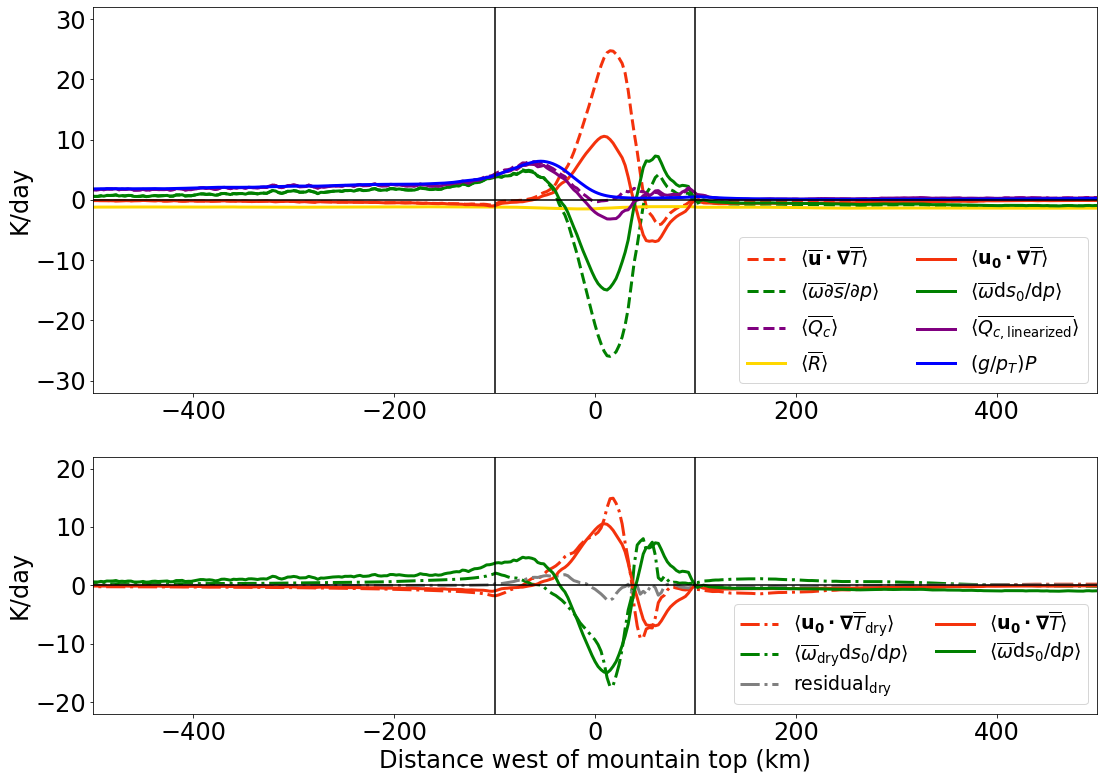

In [36]:
matplotlib.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(18,13))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,2],figure=fig)
ax  = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

ax.plot(hrdist, udtdx_p     ,linewidth=3,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion",linestyle='--')
ax.plot(hrdist, omegadsdp_p ,linewidth=3,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="green"          ,linestyle='--')
ax.plot(hrdist, Qdiab_p     ,linewidth=3,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple"        ,linestyle='--')
ax.plot(hrdist, Qrad_p      ,linewidth=3,label=r"$\langle \overline{R}                                     \rangle$", color='gold'        )

ax.plot(hrdist, u0dtdx_p    ,linewidth=3,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}     \rangle$",color="xkcd:vermillion",linestyle='-')
ax.plot(hrdist, omegads0dp_p,linewidth=3,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="green"          ,linestyle='-')
ax.plot(hrdist, Qdiab_p_lin ,linewidth=3,label=r"$\langle\overline{Q_{c,\mathrm{linearized}}}        \rangle$",color="purple"         ,linestyle='-')
ax.plot(hrdist, hrpr_K      ,linewidth=3,label=r"$(g/p_T)P$", color='b')


ax2.plot(hrdist, dryu0dtdx_p    ,linewidth=3,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="xkcd:vermillion" ,linestyle='-.')
ax2.plot(hrdist, dryomegads0dp_p,linewidth=3,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="green"           ,linestyle='-.')
ax2.plot(hrdist, dryu0dtdx_p +dryomegads0dp_p   ,linewidth=3,label=r"residual$_\mathrm{dry}$",color="grey" ,linestyle='-.')

ax2.plot(hrdist, u0dtdx_p       ,linewidth=3,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}                  \rangle$",color="xkcd:vermillion" ,linestyle='-')
ax2.plot(hrdist, omegads0dp_p   ,linewidth=3,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p              \rangle$",color="green"           ,linestyle='-')


#ax2.plot(hrdist, u0dtdx_p-dryu0dtdx_p         ,linewidth=3,label=r"$\mathbf{u_0 \cdot \nabla } (\overline{T}-\overline{T}_{\mathrm{dry}})$"     ,color="xkcd:vermillion")
##ax2.plot(hrdist, omegads0dp_p-dryomegads0dp_p ,linewidth=3,label=r"$(\overline{\omega}-\overline{\omega}_{\mathrm{dry}}) \mathrm{d}s_0/\mathrm{d}p $",color="green")
#ax2.plot(hrdist, omegads0dp_p-dryomegads0dp_p-Qrad_p,linewidth=3,label=r"$\overline{Q_\mathrm{diab,moist}}$", color="magenta")
#ax2.plot(hrdist, hrpr_K,linewidth=3,label=r"$(g/p_T) P/C_p$", color='b')


for a in ax,ax2:
    a.axvline(-100.,color='k')
    a.axvline(100.,color='k')
    a.axhline(0.,color='k')
    a.set_xlim(-500,500)
    a.set_ylabel("K/day")
ax.legend(ncol=2,loc=4,fontsize=19)
ax2.legend(ncol=2,loc=4,fontsize=19,labelspacing=0.2,borderpad=0.3,columnspacing=1.5)
ax.set_ylim(-32,32)
ax2.set_ylim(-22,22)
ax2.set_xlabel("Distance west of mountain top (km)")


# Figure 7 - $\hat T_d$ and $\hat q_d$

In [43]:
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
qmean = qmean.where(qmean >0.)  
qmean_p = change_coords_pl(hrchannel_p,qmean)[5:-4]

dryqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.Q_PL.days50-100.nc')
dryqmean   = dryqmean.where(dryqmean >0.)  
dryqmean_p = change_coords_sfc(dryqmean)[::-1][4:]


In [44]:
%%time 
Pmean = change_coords_eta(hrchannel,(hrchannel.PB[600,:,0,:]+hrchannel.P[600:650,:,:,].mean(['Time','south_north']))).load()
psfc=change_coords_sfc(hrchannel.PSFC[-10:,:,:].mean(['Time','south_north'])).load()

CPU times: user 2.28 s, sys: 4.61 s, total: 6.89 s
Wall time: 23.4 s


In [91]:
tmean_p.pressure[0:7]

<xarray.DataArray 'pressure' (pressure: 7)>
array([875., 850., 825., 800., 775., 750., 700.], dtype=float32)
Coordinates:
  * pressure  (pressure) float32 875.0 850.0 825.0 800.0 775.0 750.0 700.0

In [45]:
def hatprime(var,idx1,idx2):
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')
def hatprime_2(var,psfc,deltap1,deltap2):
    varprime = var - var[:,2200:2400].mean('distance_from_mtn')
    varhatprime = varprime.where((varprime.pressure<=psfc-deltap1)&(varprime.pressure>=psfc-deltap2)).mean('pressure')
    return varhatprime

tmean_p_hat_prime         = hatprime(tmean_p,0,7)
drytmean_p_hat_prime      = hatprime(drytmean_p,0,7)

qmean_p_hat_prime         = 2.5e6/1004.*hatprime(qmean_p,0,7)
dryqmean_p_hat_prime      = 2.5e6/1004.*hatprime(dryqmean_p,0,7)

tmean_p_hat_prime2         = hatprime_2(tmean_p,   psfc/100,100,300)
drytmean_p_hat_prime2      = hatprime_2(drytmean_p,psfc/100,100,300)

qmean_p_hat_prime2         = 2.5e6/1004.*hatprime_2(qmean_p,   psfc/100,100,300)
dryqmean_p_hat_prime2      = 2.5e6/1004.*hatprime_2(dryqmean_p,psfc/100,100,300)


In [46]:
def linear_Td_qd(u,kind='gaussian',a=100e3,A=1000):
    xx=np.arange(-10000e3,20000e3,5e3)
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    elif kind=='agnesi':
        hx = A*a**2/(xx**2+a**2)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])

    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    N=np.sqrt(9.81/300 * ds0dz/1004.)
    
    Tdhat = -ds0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,u)  *  z_slice[None,:]).mean(axis=1) 
    qdhat = -dq0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,u)  *  z_slice[None,:]).mean(axis=1) 
    
    return xx,np.real(np.fft.ifft(Tdhat))/1004.,np.real(np.fft.ifft(qdhat))/1004.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


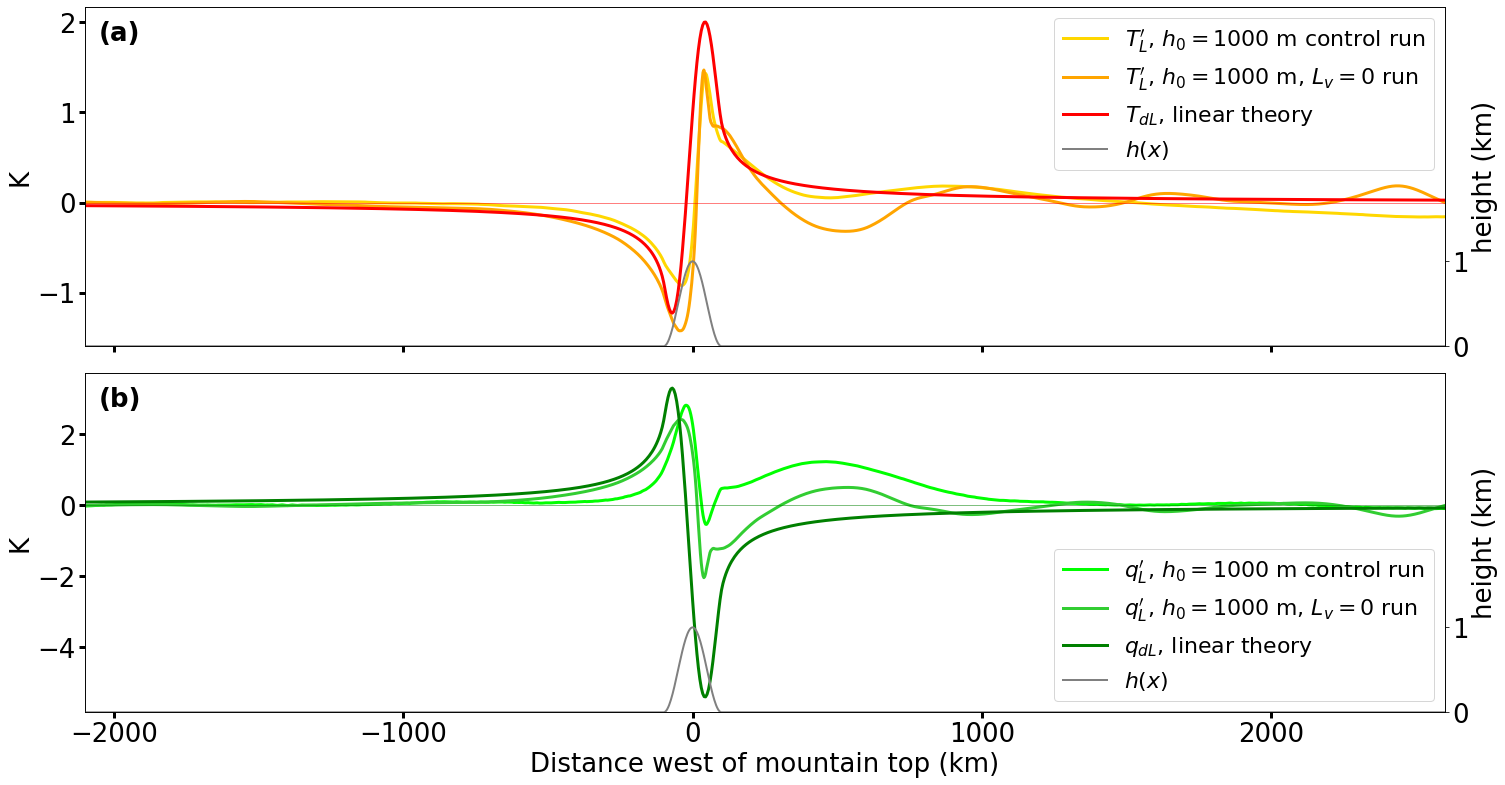

In [139]:
matplotlib.rcParams.update({'font.size': 26})
x,Td_hat_linear,qd_hat_linear = linear_Td_qd(10,kind='cos')

fig,(ax,ax2) = plt.subplots(2,1,figsize=(21,11))
axm=ax.twinx()
ax2m=ax2.twinx()

tmean_p_hat_prime.plot(   ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=1000$ m control run")
drytmean_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=1000$ m, $L_v=0$ run")
ax.plot(x/1000,Td_hat_linear,   color='red'   ,linewidth=3,label=r"$T_{dL}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')
#tmean_p_hat_prime2.plot(   ax=ax,color='r'  ,linewidth=3,label=r"$T_L'$, 1000 m moist simulation")
#drytmean_p_hat_prime2.plot(ax=ax,color='m',linewidth=3,label=r"$T_L'$, 1000 m dry simulation")


qmean_p_hat_prime.plot(   ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=1000$ m control run")
dryqmean_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=1000$ m, $L_v=0$ run")
ax2.plot(x/1000,qd_hat_linear,   color='green'    ,linewidth=3,label=r"$q_{dL}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')

#qmean_p_hat_prime2.plot(   ax=ax2,color='c'     ,linewidth=3,label=r"$q_L'$, 1000 m moist simulation")
#dryqmean_p_hat_prime2.plot(ax=ax2,color='b',linewidth=3,label=r"$q_L'$, 1000 m dry simulation")


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-2100,2600)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    a.tick_params(width=3,length=6)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=22)
ax2.legend(lines + lines2, labels + labels2,fontsize=22,loc=4)
 
ticks=range(-2000,3000,1000)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))

ax.set_xlabel('')
ax2.set_xlabel('Distance west of mountain top (km)')
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
fig.tight_layout(pad=0.4)

fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/TLqL.eps',bbox_inches='tight')

# Figure 8 - Unfitted and fitted precip

In [62]:
lmchannel_p=extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmtmean   = lmtmean.where(lmtmean >100.)  
lmtmean_p =     change_coords_pl(lmchannel_p,lmtmean)[4:]
lmtmean_p_hat_prime = hatprime(lmtmean_p,0,7)

In [63]:
from scipy.integrate import cumtrapz,odeint

def precip_analytical_T(That,qhat,u,tauT=3,tauq=11,alpha=None,how="nonlinear",P0=4.5):
    x=1000*hrdist[::-1]
    Lc = 2.5e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    
    #P0 = 4.5 # mm/day
    P0_Kps = Lc*P0/86400/M
    
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    
    Lq=5.2*u*tauqtilde
        
    if how=="linear":
        if alpha is None:
            alpha = 0*x
        f = cumtrapz(np.exp(x/Lq)*(P0_Kps/Lq*alpha+np.gradient(qhat,x)/tauq-np.gradient(That,x)/tauT),x,initial=0)
        return np.maximum(0.,P0+ 86400 * M / Lc * np.exp(-x/Lq)*f)
    elif how=="nonlinear":
        x=np.array(x)
        qhat=np.array(qhat)
        That=np.array(That)
        conv=1/ 2.5e6 * 86400 * 8000
        if alpha is None:
            alpha = 0*x
        def fun(qmhovt,a,how):
            ix=np.argmin((x-a)**2)
            return -1/Lq* (np.maximum(0.,qmhovt+(qhat*conv/tauq-That*conv/tauT)[ix])-P0*(1+alpha[ix]))
            #return -1/Lq* (qmhovt+(qhat*conv/tauq-That*conv/tauT)[ix]-P0*(1+alpha[ix]))
        qmhovt = odeint(fun,P0,x,args=(how,))[:,0]
        return np.maximum(0.,qmhovt+qhat*conv/tauq-That*conv/tauT)
    else:
        raise ValueError("how should be linear or nonlinear")
    


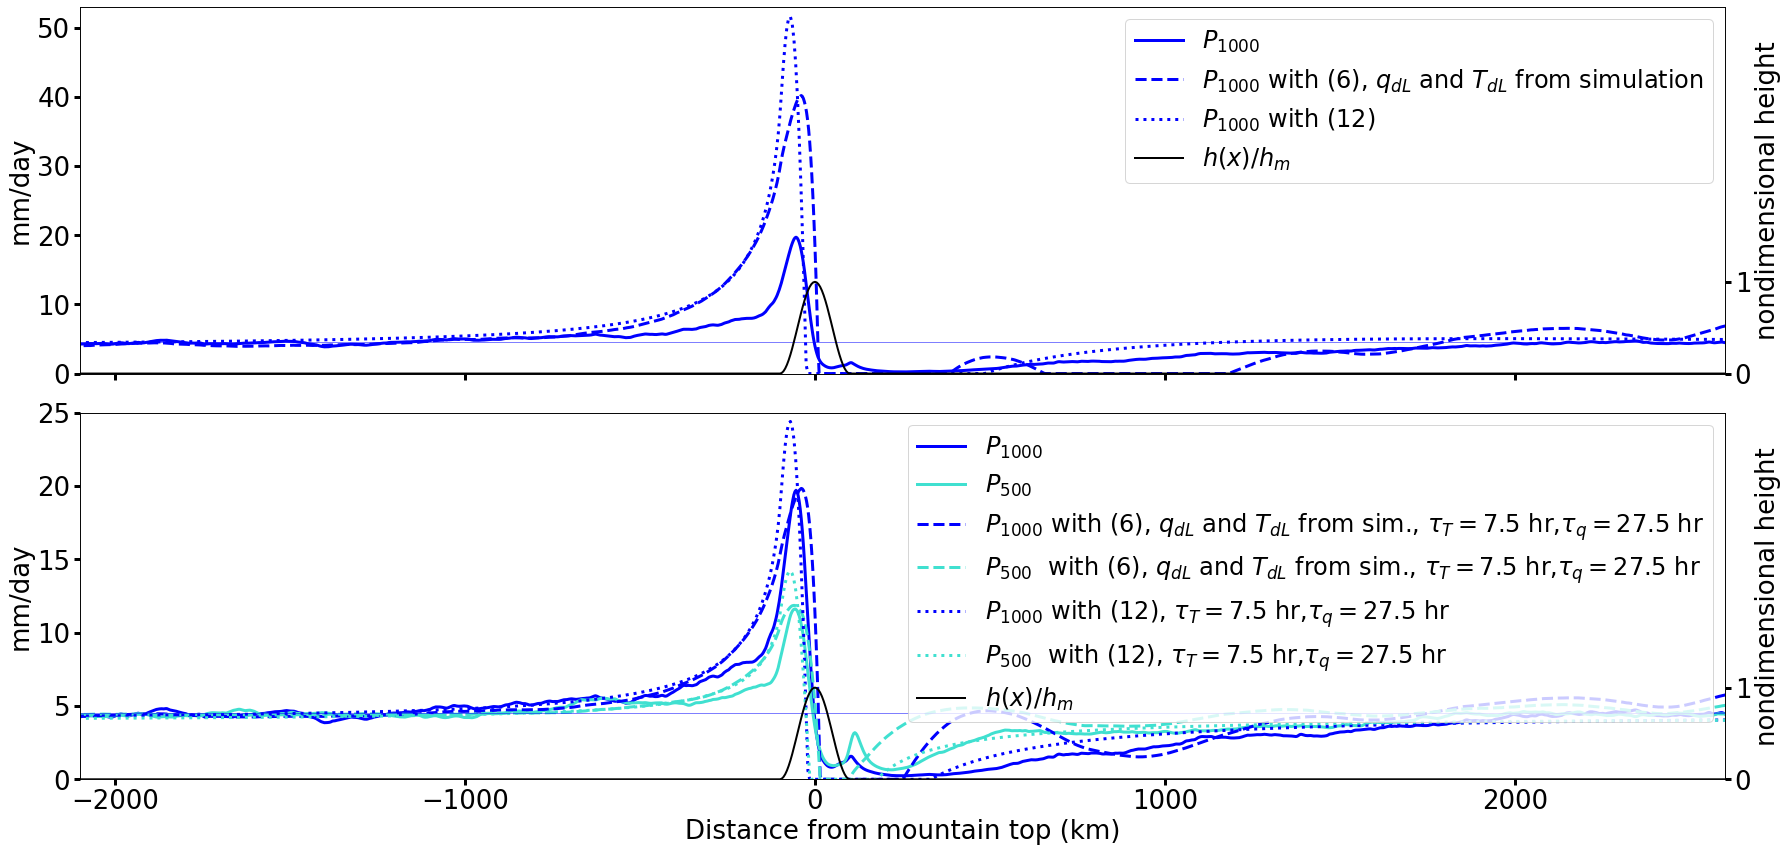

In [59]:
matplotlib.rcParams.update({'font.size': 26})

#x,hx,Plin = linear_p_theory(10,kind='cos',a=100e3,A=1000,P0=4)
#Pnonlin=precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10)
#
#x,hx,Plin_fit = linear_p_theory(10,kind='cos',a=100e3,A=1000,tauT=7.5,tauq=27.5)
#x,_,Plin500_fit = linear_p_theory(10,kind='cos',a=100e3,A=500,tauT=7.5,tauq=27.5)
#Pnonlin_fit   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)
#lmPnonlin_fit = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)
#x/=1000

lw=3

fig,(ax,ax2)=plt.subplots(2,1,figsize=(25,12))
axm=ax.twinx()
axm2=ax2.twinx()

## Top panel
ax.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,Pnonlin[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from simulation",color='b',linestyle='--',linewidth=lw)
ax.plot(x,Plin,                   label=r"$P_{1000}$ with (12)",color='b',linestyle=':',linewidth=lw)

## Bottom panel
ax2.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,lmpr,              label=r"$P_{500}$",color='turquoise',linewidth=lw)

ax2.plot(hrdist,Pnonlin_fit[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax2.plot(hrdist,lmPnonlin_fit[::-1],label=r"$P_{500}$  with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)

ax2.plot(x,Plin_fit,   label=r"$P_{1000}$ with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)
ax2.plot(x,Plin500_fit,label=r"$P_{500}$  with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)

ax.set_ylim(0,53)
ax2.set_ylim(0,25)

for i,(a,am) in enumerate(zip((ax,ax2),(axm,axm2))):
    am.plot(x,hx/1000,label=r"$h(x)/h_0$",color='k',linewidth=2)
    
    a.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
    a.set_ylabel(r'mm day$^{-1}$')
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==1:
        a.set_xlabel('Distance west of mountain top (km)')
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
    
    am.set_ylabel('nondimensional height')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
fig.tight_layout(pad=0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


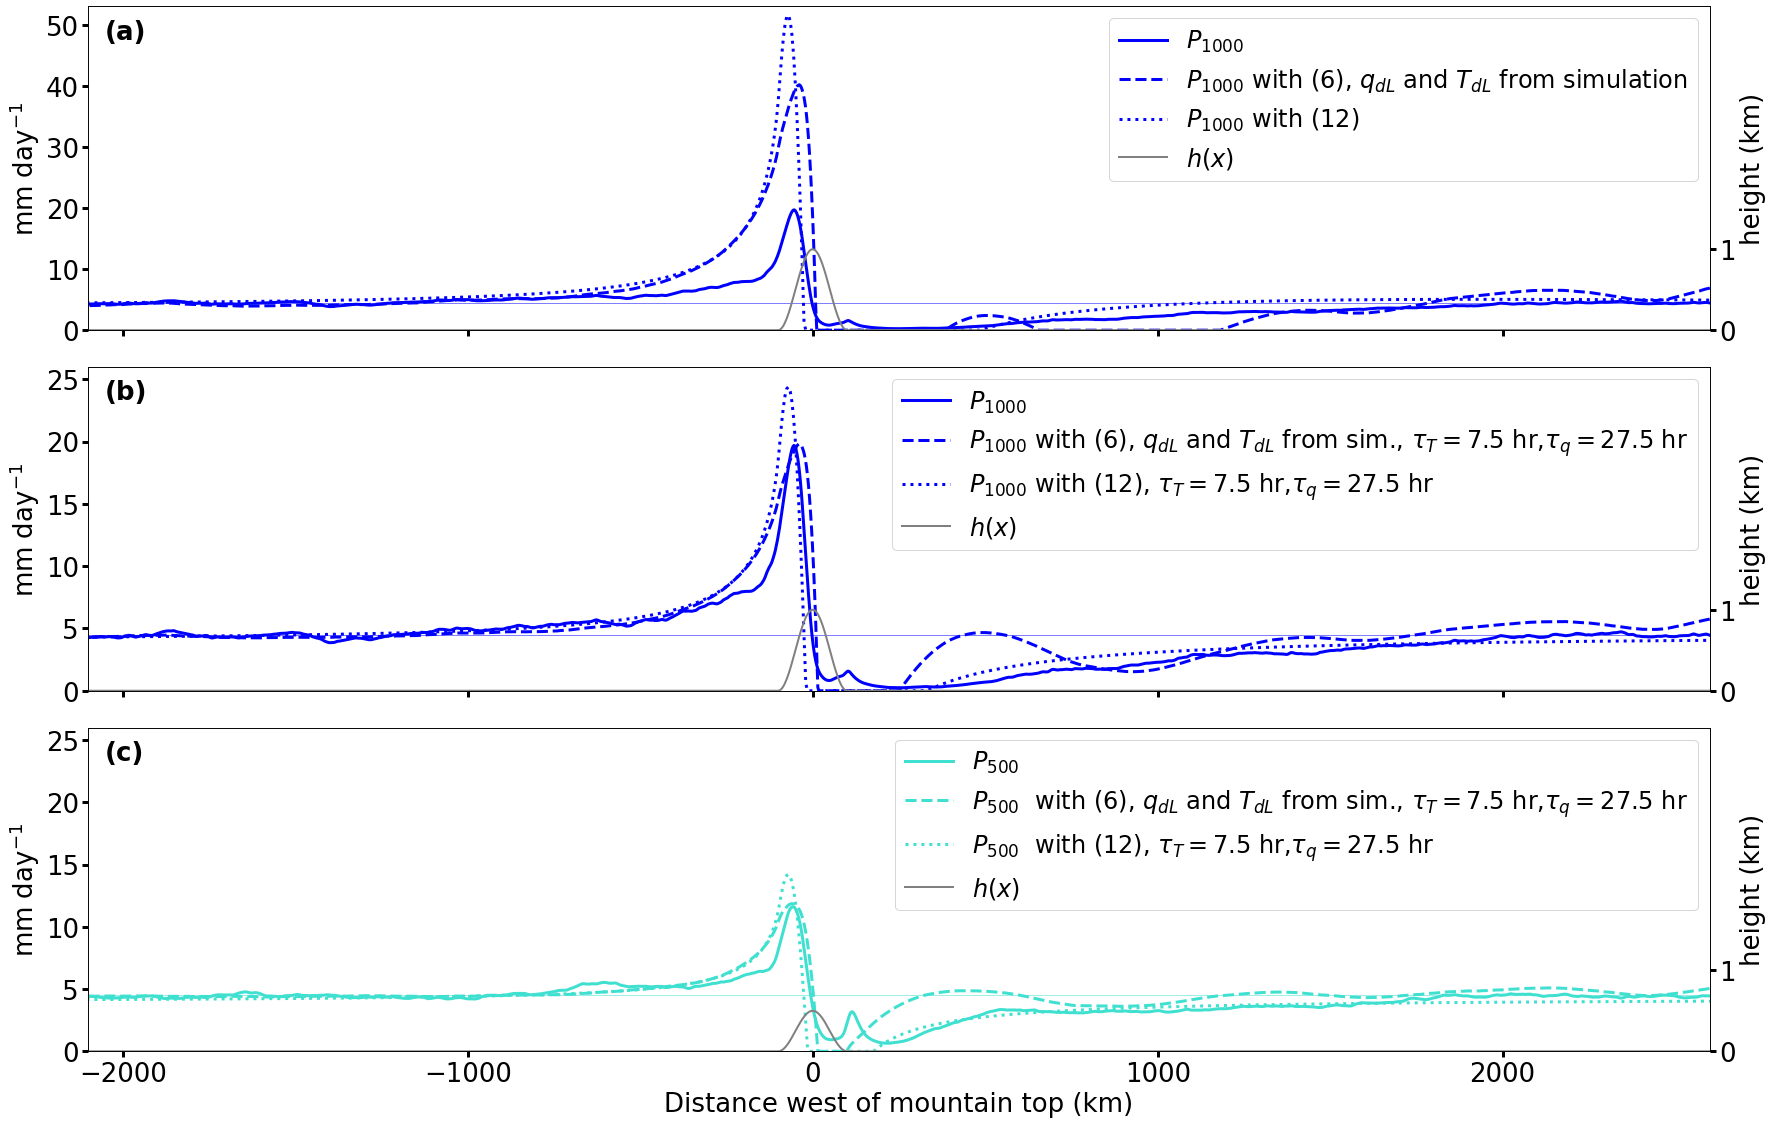

In [142]:
matplotlib.rcParams.update({'font.size': 26})

x,hx,Plin = linear_p_theory(10,kind='cos',a=100e3,A=1000,P0=4)
#Pnonlin=precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10)

x,hx,Plin_fit = linear_p_theory(10,kind='cos',a=100e3,A=1000,tauT=7.5,tauq=27.5)
x,_,Plin500_fit = linear_p_theory(10,kind='cos',a=100e3,A=500,tauT=7.5,tauq=27.5)
#Pnonlin_fit   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)
#lmPnonlin_fit = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)
x/=1000

lw=3

fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(25,16))
axm=ax.twinx()
axm2=ax2.twinx()
axm3=ax3.twinx()

## Top panel
ax.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,Pnonlin[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from simulation",color='b',linestyle='--',linewidth=lw)
ax.plot(x,Plin,                   label=r"$P_{1000}$ with (12)",color='b',linestyle=':',linewidth=lw)

## Middle panel
ax2.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,Pnonlin_fit[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax2.plot(x,Plin_fit,   label=r"$P_{1000}$ with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)

## Bottom panel
ax3.plot(hrdist,lmpr,              label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax3.plot(hrdist,lmPnonlin_fit[::-1],label=r"$P_{500}$  with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)
ax3.plot(x,Plin500_fit,label=r"$P_{500}$  with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)


ax.set_ylim(0,53)
ax2.set_ylim(0,26)
ax3.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2,ax3),(axm,axm2,axm3))):
    a.set_ylabel(r'mm day$^{-1}$')
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==2:
        a.set_xlabel('Distance west of mountain top (km)')
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='turquoise')
        am.plot(hrdist,hrhgt/2000,label=r"$h(x)$",color='gray',linewidth=2)
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
        am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
fig.tight_layout(pad=0.8)
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
ax3.text(0.01, 0.9,'(c)', transform=ax3.transAxes,color='k',weight='bold')

fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/Pcompare.eps',bbox_inches='tight')

# Figure 9 - evaporation and radiative cooling profiles

In [73]:
hrhfx   = hrchannel.HFX.isel(Time=slice(200,800)).mean(['south_north','Time']).persist()
hrlh    = hrchannel.LH.isel(Time=slice(200,800)).mean(['south_north','Time']).persist()

In [74]:
%%time
def rad_cooling(sim,t1,t2):
    mSWUPT = (sim.ACSWUPT.isel(Time = t2)-sim.ACSWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = t2)-sim.ACSWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = t2)-sim.ACSWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = t2)-sim.ACSWDNB.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = t2)-sim.ACLWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = t2)-sim.ACLWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = t2)-sim.ACLWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = t2)-sim.ACLWDNB.isel(Time = t1))/(t2-t1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
hrradc = rad_cooling(hrchannel,200,800).mean(['south_north']).load()
hrevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 1.53 s, sys: 9.51 s, total: 11 s
Wall time: 13.1 s


In [75]:
%%time
lmradc = rad_cooling(lmchannel,200,800).mean(['south_north']).load()
lmevap = lmchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 903 ms, sys: 1min 27s, total: 1min 28s
Wall time: 1min 51s


In [76]:
%%time
Ms = 2370
Mh = 455
Mq = Ms-Mh

hrevap_prime = hrevap/hrevap[2000:3000].mean() - 1
hrradc_prime = hrradc/hrradc[2000:3000].mean() - 1

hralpha_evap_rad1 = np.array((Ms*hrevap_prime)/Mh)[::-1]
hralpha_evap1_rad = np.array((-Mq*hrradc_prime)/Mh)[::-1]

hralpha_evap_rad = np.array((Ms*hrevap_prime-Mq*hrradc_prime)/Mh)[::-1]

CPU times: user 3.17 ms, sys: 2.83 ms, total: 6 ms
Wall time: 4.89 ms


In [77]:
%%time
Ms = 2341
Mh = 450
Mq = Ms-Mh

lmevap_prime = lmevap/lmevap[2000:3000].mean() - 1
lmradc_prime = lmradc/lmradc[2000:3000].mean() - 1

lmalpha_evap_rad1 = np.array((Ms*lmevap_prime)/Mh)[::-1]
lmalpha_evap1_rad = np.array((-Mq*lmradc_prime)/Mh)[::-1]

lmalpha_evap_rad = np.array((Ms*lmevap_prime-Mq*lmradc_prime)/Mh)[::-1]

CPU times: user 2.58 ms, sys: 2.01 ms, total: 4.59 ms
Wall time: 3.62 ms


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


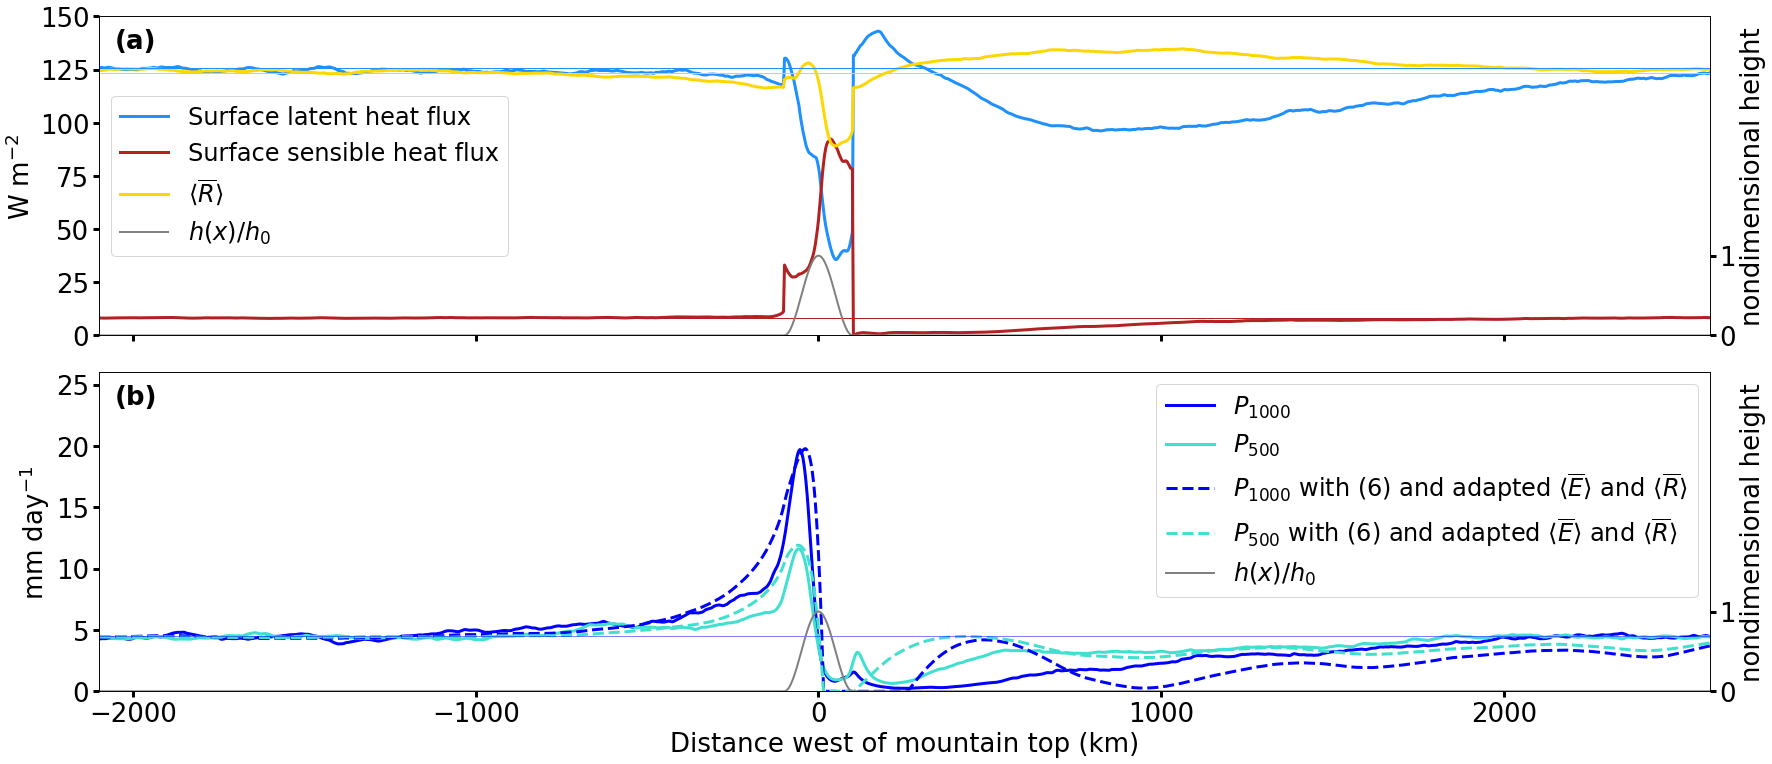

In [145]:
#Pnonlin_e = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5,alpha=hralpha_evap_rad)
#lmPnonlin_e = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,alpha=lmalpha_evap_rad)
 
matplotlib.rcParams.update({'font.size': 26})

lw=3
lwl=1

fig,(ax,ax2)=plt.subplots(2,1,figsize=(25,11))
axm=ax.twinx()
axm2=ax2.twinx()

## Top panel - fluxes
ax.plot(hrdist,hrlh, label=r"Surface latent heat flux",color='dodgerblue',linewidth=lw)
ax.plot(hrdist,hrhfx, label=r"Surface sensible heat flux",color='firebrick',linewidth=lw)
ax.plot(hrdist,hrradc, label=r"$\langle\overline{R}\rangle$",color='gold',linewidth=lw)
ax.axhline(hrlh[2200:3000].mean(),linestyle='-',linewidth=lwl,color='dodgerblue')
ax.axhline(hrhfx[2200:3000].mean(),linestyle='-',linewidth=lwl,color='firebrick')
ax.axhline(hrradc[2200:3000].mean(),linestyle='-',linewidth=lwl,color='gold')
ax.set_ylabel(r'W m$^{-2}$')
ax.set_ylim(0,150)

## Bottom panel
ax2.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,lmpr,              label=r"$P_{500}$",color='turquoise',linewidth=lw)

ax2.plot(hrdist,Pnonlin_e[::-1],label=r"$P_{1000}$ with (6) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='b',linestyle='--',linewidth=lw)
ax2.plot(hrdist,lmPnonlin_e[::-1],label=r"$P_{500}$ with (6) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='turquoise',linestyle='--',linewidth=lw)


ax2.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2),(axm,axm2))):
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)
    
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==1:
        a.set_xlabel('Distance west of mountain top (km)')
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
    
    am.set_ylabel('nondimensional height')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)
    
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.8)
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/evaprad.eps',bbox_inches='tight')

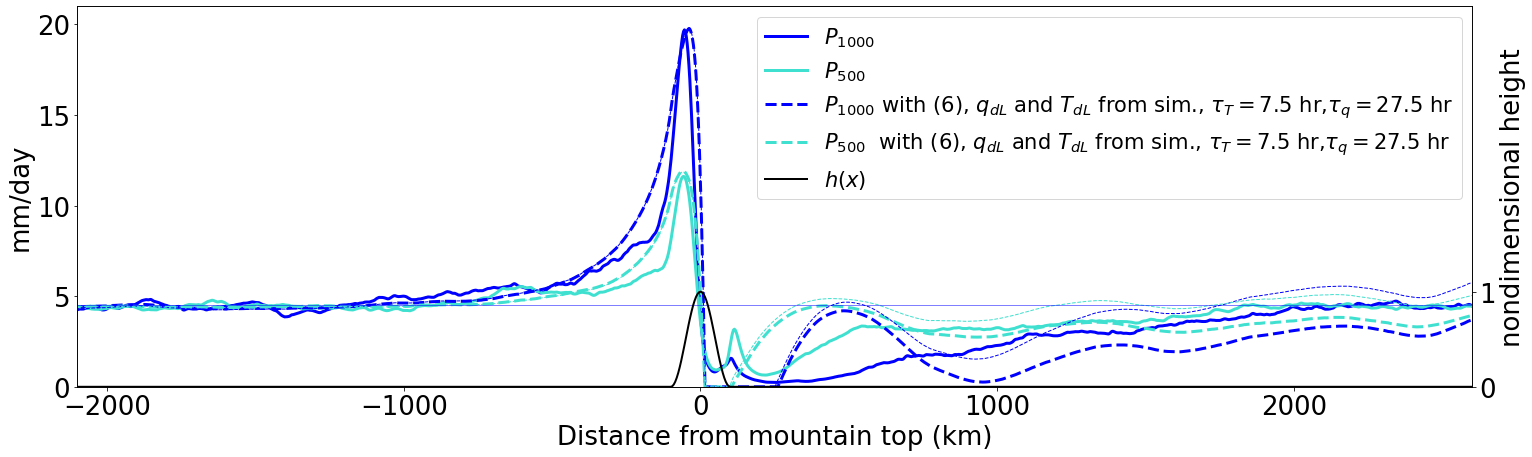

In [43]:
matplotlib.rcParams.update({'font.size': 26})

x,hx,Plin = linear_p_theory(10,kind='cos',a=100e3,A=1000,tauT=7.5,tauq=27.5)
x,_,Plin500 = linear_p_theory(10,kind='cos',a=100e3,A=500,tauT=7.5,tauq=27.5)
##Pnonlin_e   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=3,tauq=11,alpha=hralpha_evap_rad,P0=8)
Pnonlin_e = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5,alpha=hralpha_evap_rad)
lmPnonlin_e = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,alpha=lmalpha_evap_rad)
 
Pnonlin2   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)
lmPnonlin2 = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)
 

x/=1000
lw=3
lw2=1

fig,ax=plt.subplots(1,1,figsize=(25,7))
ax2=ax.twinx()

# precips
ax.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,lmpr,              label=r"$P_{500}$",color='turquoise',linewidth=lw)


ax.plot(hrdist,Pnonlin_e[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax.plot(hrdist,lmPnonlin_e[::-1],label=r"$P_{500}$  with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)

#ax.plot(x,Plin,   label=r"$P_{1000}$ with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)
#ax.plot(x,Plin500,label=r"$P_{500}$  with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)

ax.plot(hrdist,Pnonlin2[::-1],color='b',linestyle='--',linewidth=lw2)
ax.plot(hrdist,lmPnonlin2[::-1],color='turquoise',linestyle='--',linewidth=lw2)



# mountain
ax2.plot(x,hx/1000,label=r"$h(x)$",color='k',linewidth=2)

ax.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,2.6e3)
ax.set_ylim(0,21)

ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,4)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=21)


# Figure B1 - hovmoeller diagram of precipitation

In [79]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [80]:
hrchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.hourly.days0-200.nc')
hrchannelprecip_hov_all = change_coords_sfc(hrchannelprecip_hourly[1200:].mean('south_north'))

In [132]:
#%%time # takes 6 min
#def select_hov_t(t0,t,d):
#    return ((t>=t0-.5+(d+4902)/36) & (t<=t0+.5+(d+4902)/36))
#
#n=len(hrchannelprecip_hov_all.Time)-300
#p_charac=np.zeros(n)
#for t in range(n):
#    if t%25==0:
#        print(t,end=' ')
#    p_charac[t] = float(hrchannelprecip_hov_all.where(select_hov_t(t,hrchannelprecip_hov_all.Time,hrchannelprecip_hov_all.distance_from_mtn))[t:t+300].mean())
#
#p_charac = xr.DataArray(p_charac,coords={'Time':hrchannelprecip_hov_all.Time[:-300]},dims=['Time'])
#p_charac.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.pcharac.days50-188.nc")

CPU times: user 2.24 s, sys: 6.32 s, total: 8.56 s
Wall time: 9.2 s


In [81]:
p_charac = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.pcharac.days50-188.nc")

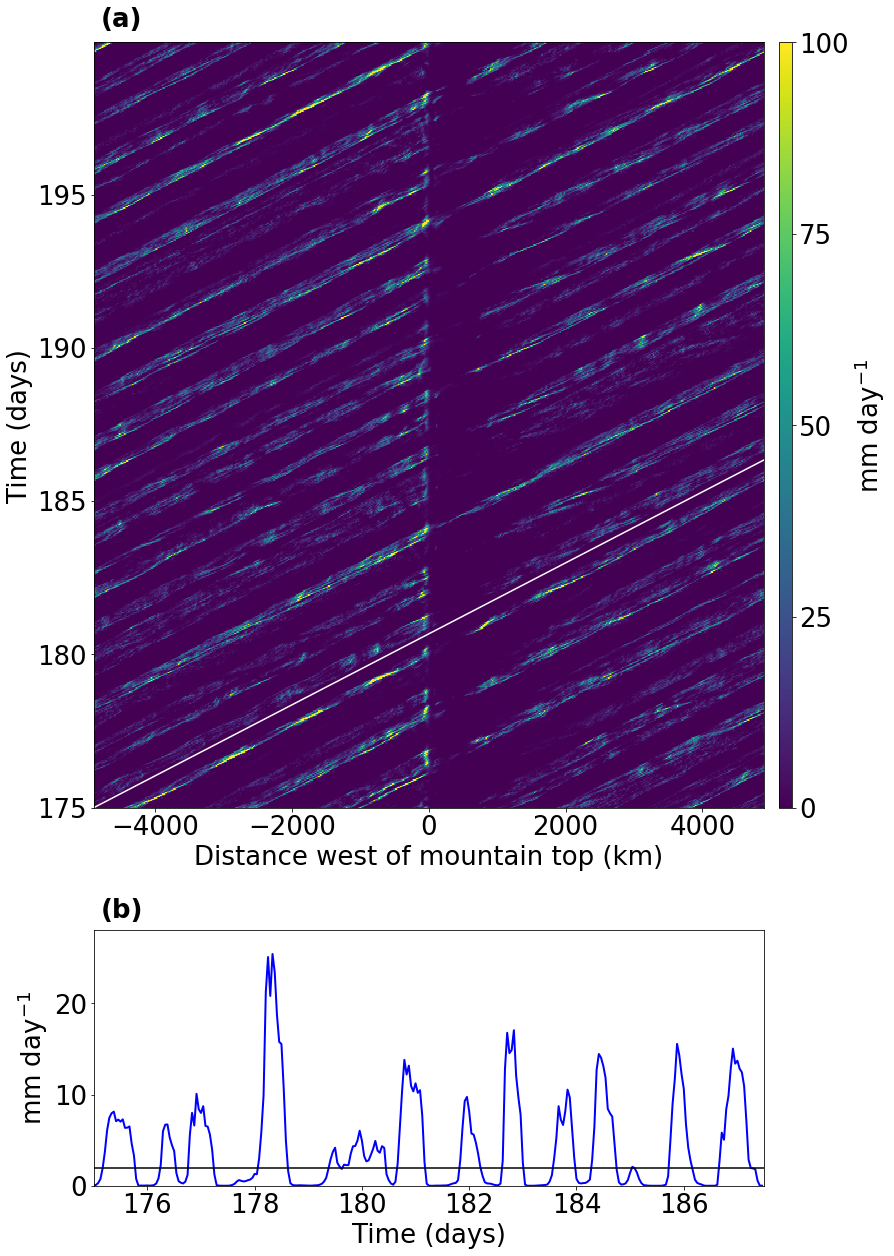

In [147]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(13,18))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,1],figure=fig)
ax = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

c=hrchannelprecip_hov_all[-600:].plot(ax=ax,vmax=100,add_colorbar=False)#,cbar_kwargs={'pad':0.2,'label':r'mm day$^{-1}$'})
ax.plot(hrchannelprecip_hov_all.distance_from_mtn,(hrchannelprecip_hov_all.distance_from_mtn+4902)*1000/(10*3600),color='w')
    
pad=.2;size="2%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$',ticks=np.arange(0,101,25))
#cax.tick_params(labelsize=20)

ax2.plot(p_charac[-300:], color='b',linewidth=2)
ax2.axhline(2.,color='k')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel('Time (days)')
ax.set_yticks(range(0,600,24*5))
ax.set_yticklabels(np.arange(0,600,24*5)//24+175)

ax2.set_ylabel(r'$t$')
ax2.set_ylabel(r'mm day$^{-1}$')

ax2.set_xlabel('Time (days)')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_xlim(0,300)
ax2.set_ylim(0,28)
ax2.set_xticks(range(24,300,24*2))
ax2.set_xticklabels(np.arange(24,300,24*2)//24+175)

ax.text(0.01, 1.02,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'(b)', transform=ax2.transAxes,color='k',weight='bold')


fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/figB1.png', dpi=300 ,bbox_inches='tight')


# Figure B2 - Mean precipitation over rainy times only

In [83]:
thresh_crossings=np.arange(len(p_charac)-1)[np.diff(p_charac>2)]
ends=thresh_crossings[1::2]+1
begs=thresh_crossings[::2][:len(ends)]

In [84]:
from functools import reduce
def select_hov_all(t,d):
    return reduce(lambda x,y:x|y,[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in zip(begs,ends)])

hrpr_rainy=hrchannelprecip_hov_all.where(select_hov_all(hrchannelprecip_hov_all.Time,hrchannelprecip_hov_all.distance_from_mtn)).mean('Time')


In [24]:
#hrpr_rainy=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.rainymean.days50-200.nc")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


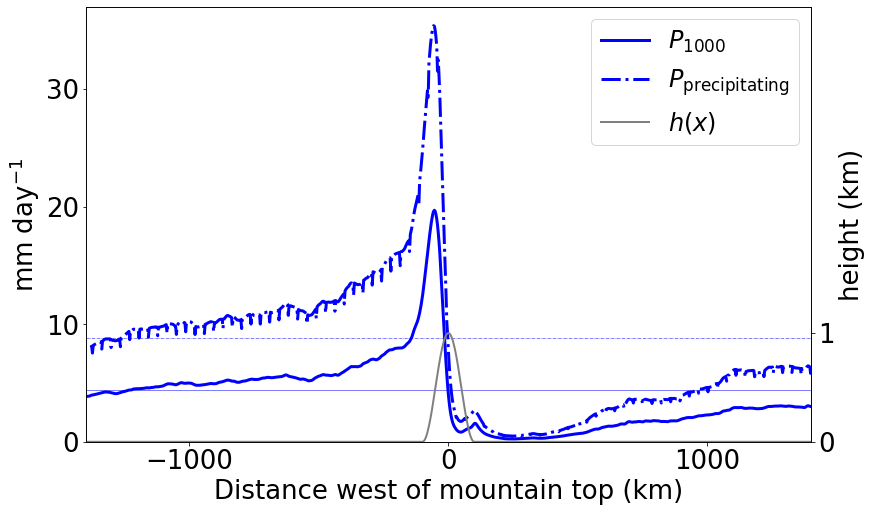

In [148]:
matplotlib.rcParams.update({'font.size': 26})

lw=3

fig,ax=plt.subplots(1,1,figsize=(13,8))
ax2=ax.twinx()

# precips
ax.plot(hrdist,hrpr,      label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,hrpr_rainy,label=r"$P_\mathrm{precipitating}$",color='b',linestyle='-.',linewidth=lw)

# mountain
ax2.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)

ax.axhline(4.4,linestyle='-',linewidth=0.5,color='b')
ax.axhline(8.8,linestyle='-.',linewidth=0.5,color='b')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-1.4e3,1.4e3)
ax.set_ylim(0,37)
ax.set_yticks(range(0,40,10))
ax.set_xticks(range(-1000,1001,1000))

ax2.set_ylabel('height (km)')
ax2.set_ylim(0,4)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)

fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/figB2.eps',bbox_inches='tight')

# Old Figure 9 - Fitted precip

In [39]:
%%time
def rad_cooling(sim,t1,t2):
    mSWUPT = (sim.ACSWUPT.isel(Time = t2)-sim.ACSWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = t2)-sim.ACSWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = t2)-sim.ACSWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = t2)-sim.ACSWDNB.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = t2)-sim.ACLWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = t2)-sim.ACLWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = t2)-sim.ACLWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = t2)-sim.ACLWDNB.isel(Time = t1))/(t2-t1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
hrradc = rad_cooling(hrchannel,200,800).mean(['south_north']).load()
hrevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 1.14 s, sys: 7.52 s, total: 8.66 s
Wall time: 15.8 s


In [40]:
%%time
lmradc = rad_cooling(lmchannel,200,800).mean(['south_north']).load()
lmevap = lmchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 903 ms, sys: 29.2 s, total: 30.1 s
Wall time: 41.2 s


In [41]:
%%time
Ms = 2370
Mh = 455
Mq = Ms-Mh

hrevap_prime = hrevap/hrevap[2000:3000].mean() - 1
hrradc_prime = hrradc/hrradc[2000:3000].mean() - 1

hralpha_evap_rad1 = np.array((Ms*hrevap_prime)/Mh)[::-1]
hralpha_evap1_rad = np.array((-Mq*hrradc_prime)/Mh)[::-1]

hralpha_evap_rad = np.array((Ms*hrevap_prime-Mq*hrradc_prime)/Mh)[::-1]

CPU times: user 0 ns, sys: 5.09 ms, total: 5.09 ms
Wall time: 3.84 ms


In [42]:
%%time
Ms = 2341
Mh = 450
Mq = Ms-Mh

lmevap_prime = lmevap/lmevap[2000:3000].mean() - 1
lmradc_prime = lmradc/lmradc[2000:3000].mean() - 1

lmalpha_evap_rad1 = np.array((Ms*lmevap_prime)/Mh)[::-1]
lmalpha_evap1_rad = np.array((-Mq*lmradc_prime)/Mh)[::-1]

lmalpha_evap_rad = np.array((Ms*lmevap_prime-Mq*lmradc_prime)/Mh)[::-1]

CPU times: user 0 ns, sys: 3.8 ms, total: 3.8 ms
Wall time: 2.96 ms


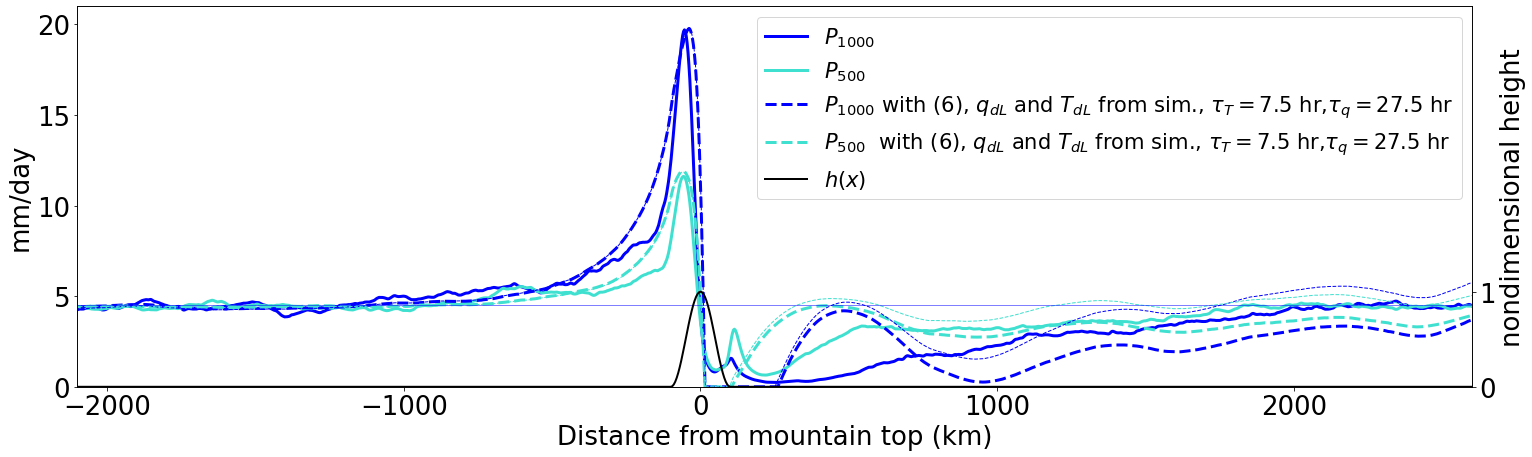

In [43]:
matplotlib.rcParams.update({'font.size': 26})

x,hx,Plin = linear_p_theory(10,kind='cos',a=100e3,A=1000,tauT=7.5,tauq=27.5)
x,_,Plin500 = linear_p_theory(10,kind='cos',a=100e3,A=500,tauT=7.5,tauq=27.5)
##Pnonlin_e   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=3,tauq=11,alpha=hralpha_evap_rad,P0=8)
Pnonlin_e = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5,alpha=hralpha_evap_rad)
lmPnonlin_e = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,alpha=lmalpha_evap_rad)
 
Pnonlin2   = precip_analytical_T(1004.*np.array(tmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)
lmPnonlin2 = precip_analytical_T(1004.*np.array(lmtmean_p_hat_prime)[::-1],1004.*np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)
 

x/=1000
lw=3
lw2=1

fig,ax=plt.subplots(1,1,figsize=(25,7))
ax2=ax.twinx()

# precips
ax.plot(hrdist,hrpr,              label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,lmpr,              label=r"$P_{500}$",color='turquoise',linewidth=lw)


ax.plot(hrdist,Pnonlin_e[::-1],label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax.plot(hrdist,lmPnonlin_e[::-1],label=r"$P_{500}$  with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)

#ax.plot(x,Plin,   label=r"$P_{1000}$ with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)
#ax.plot(x,Plin500,label=r"$P_{500}$  with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)

ax.plot(hrdist,Pnonlin2[::-1],color='b',linestyle='--',linewidth=lw2)
ax.plot(hrdist,lmPnonlin2[::-1],color='turquoise',linestyle='--',linewidth=lw2)



# mountain
ax2.plot(x,hx/1000,label=r"$h(x)$",color='k',linewidth=2)

ax.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,2.6e3)
ax.set_ylim(0,21)

ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,4)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=21)


In [15]:
pi = (drytmean_p.pressure/1e3)**0.286
rhomean_p = change_coords_pl(hrchannel_p,rhomean)[5:-4]
dsdz = 1000*pi*thetamean_p.differentiate('pressure')/100 * (-rhomean_p*9.81)

In [17]:
dryrhomean_p = change_coords_sfc(dryrhomean)[4:]
drydsdz = 1000*pi*drythetamean_p.differentiate('pressure')/100 * (-dryrhomean_p*9.81)

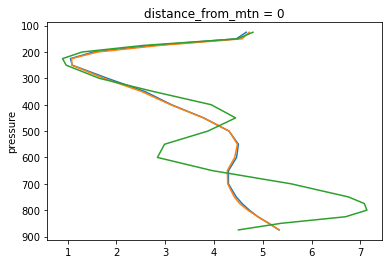

In [18]:
dsdz[:,2000].plot(y='pressure',yincrease=False)
dsdz[:,3000].plot(y='pressure',yincrease=False)
dsdz[:,1635].plot(y='pressure',yincrease=False)

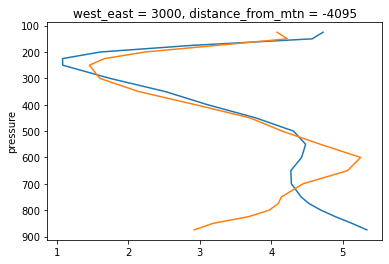

In [19]:
dsdz[:,3000].plot(y='pressure',yincrease=False)
drydsdz[:,3000].plot(y='pressure',yincrease=False)

# Figure ? - x-z cross section of temperature deviation from upstream

In [18]:
tmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc'),staggered=False)
tmean_sp = interp_eta_to_pressure(hrchannel,tmean_s,staggered=0)
drytmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.TEMP.days50-100.nc'),staggered=False)
drytmean_sp = interp_eta_to_pressure(dryhrchannel,drytmean_s,staggered=0)


In [19]:
rhomean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc'),staggered=False)
rhomean_sp = interp_eta_to_pressure(hrchannel,rhomean_s,staggered=0)
dryrhomean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO.days50-100.nc'),staggered=False)
dryrhomean_sp = interp_eta_to_pressure(dryhrchannel,dryrhomean_s,staggered=0)


In [20]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wmean_sp = interp_eta_to_pressure(hrchannel,wmean_s,staggered=1)
drywmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)
drywmean_sp = interp_eta_to_pressure(dryhrchannel,drywmean_s,staggered=1)


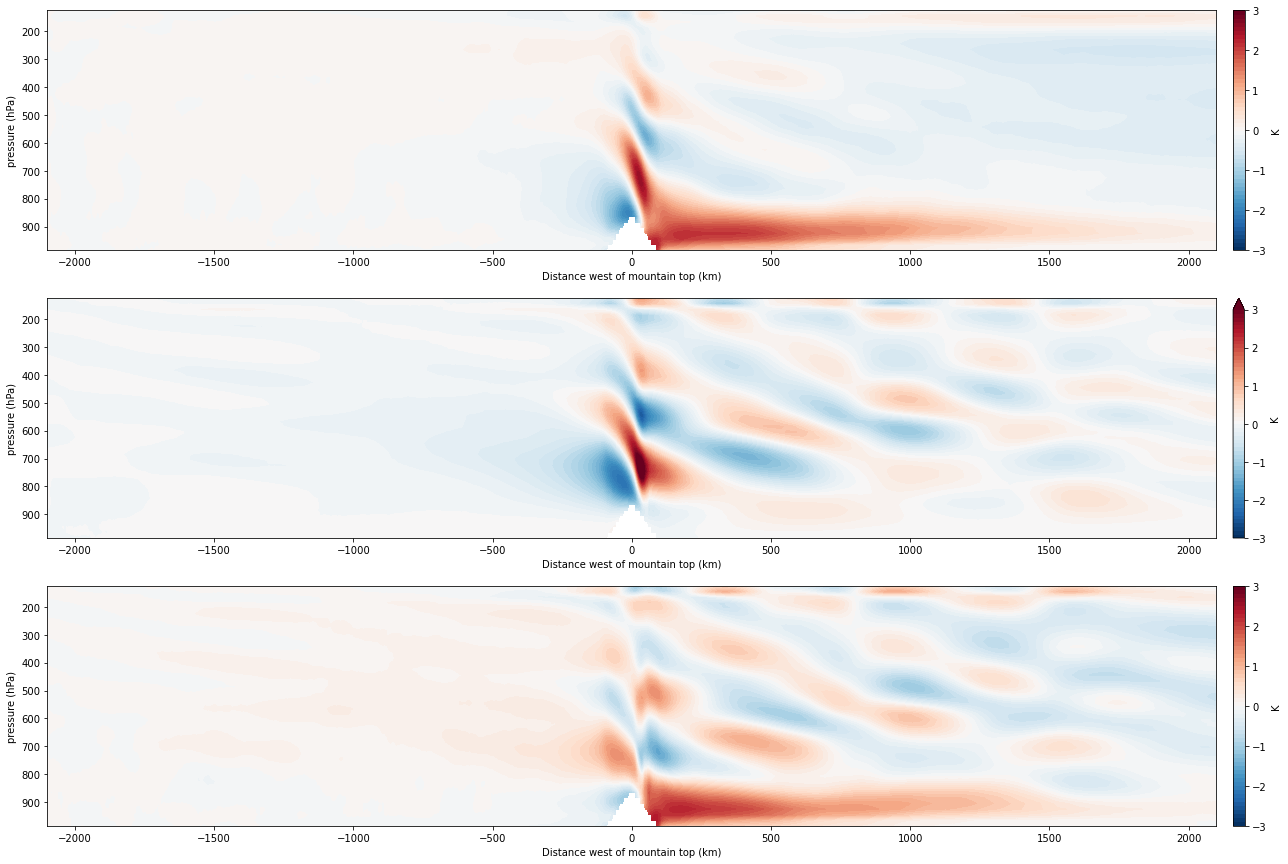

In [115]:
fig,axs=plt.subplots(3,1,figsize=(25,15))
tlevs=np.arange(-3,3.01,0.1)
tticks=np.arange(-3,3.01,1)

ax=axs[0]
(tmean_sp-tmean_sp[:,2200:2400].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})

ax=axs[1]
(drytmean_sp-drytmean_sp[:,2200:2400].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})

ax=axs[2]
((tmean_sp-tmean_sp[:,2200:2400].mean('distance_from_mtn'))-(drytmean_sp-drytmean_sp[:,2200:2400].mean('distance_from_mtn'))).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})


for ax in axs:
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-2100,2100)
    #ax.axhline(875.,linewidth=0.5)
    #ax.axhline(700.,linewidth=0.5)
    #ax.axhline(500.,linewidth=0.5,linestyle='--')
    #ax.axhline(250.,linewidth=0.5,linestyle=':')

In [112]:
dryqmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.QVAPOR.days50-100.nc'),staggered=False)
dryqmean_sp = interp_eta_to_pressure(dryhrchannel,dryqmean_s,staggered=0)


(-2100.0, 2100.0)

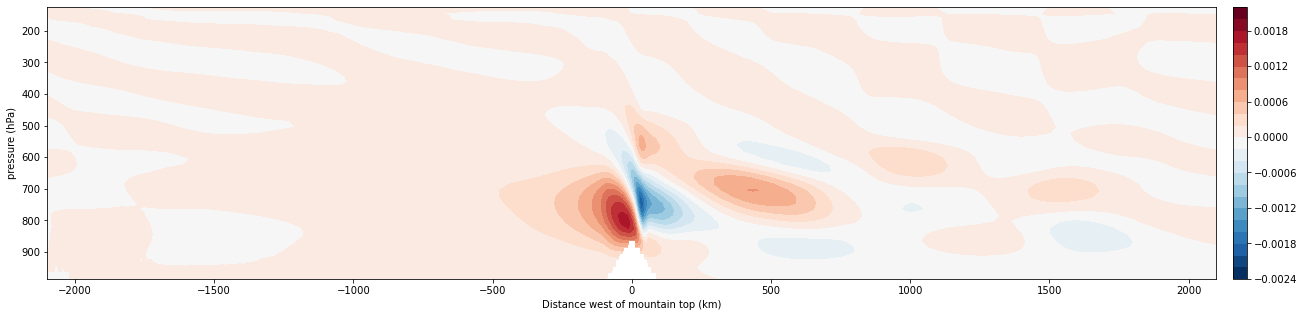

In [115]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
tlevs=np.arange(-0.0024,0.0024,0.0002)
#tticks=np.arange(-3,3.01,1)

(dryqmean_sp-dryqmean_sp[:,2200:2400].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'pad':.012})

ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("pressure (hPa)")
ax.set_xlim(-2100,2100)


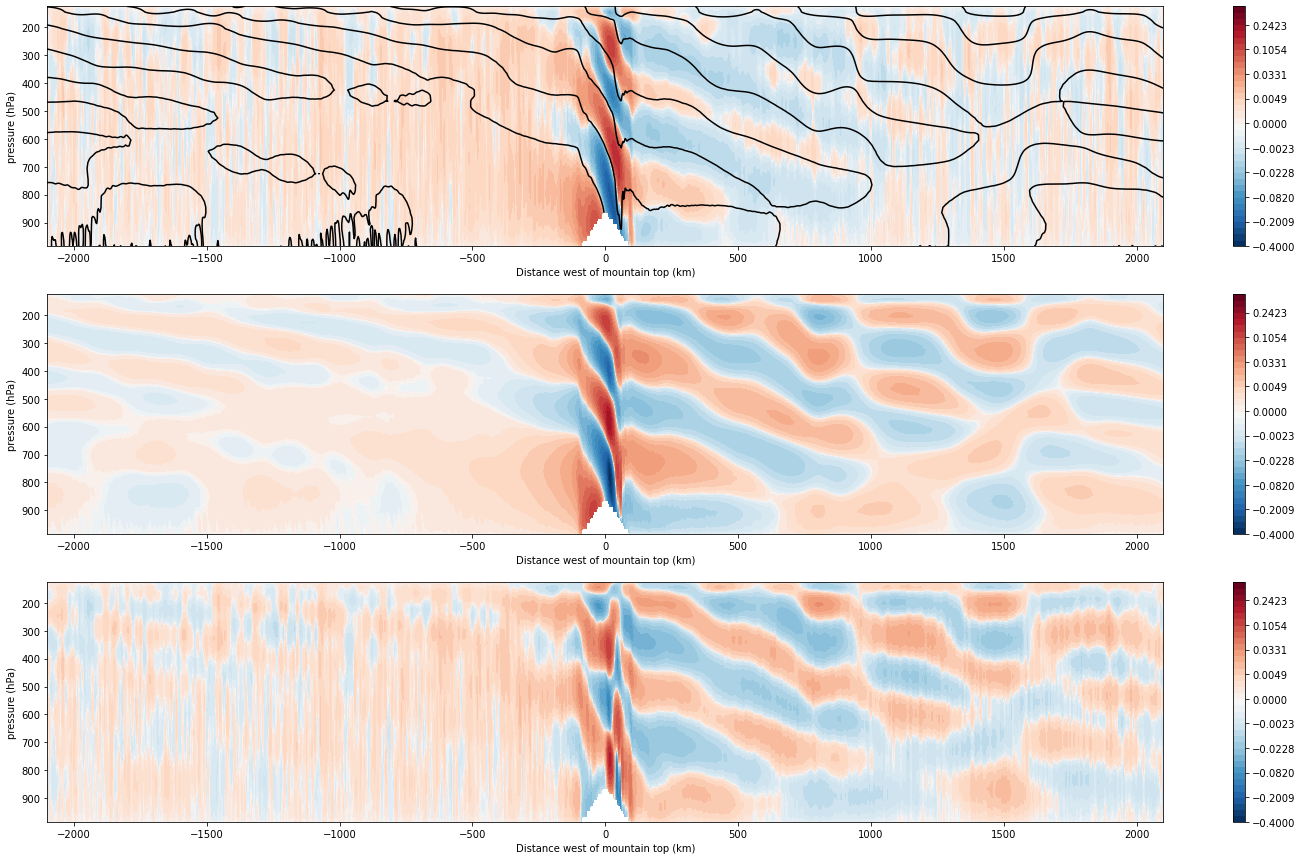

In [116]:
fig,axs=plt.subplots(3,1,figsize=(25,15))
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n
wlevs=levs(0.4,3)

ax=axs[0]
wmean_sp.plot.contourf(ax=ax,yincrease=False,levels=wlevs)
drywmean_sp.plot.contour(ax=ax,yincrease=False,levels=[0.],colors=['k'])


ax=axs[1]
drywmean_sp.plot.contourf(ax=ax,yincrease=False,levels=wlevs)

ax=axs[2]
(wmean_sp-drywmean_sp).plot.contourf(ax=ax,yincrease=False,levels=wlevs)


for ax in axs:
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-2100,2100)
    #ax.axhline(875.,linewidth=0.5)
    #ax.axhline(700.,linewidth=0.5)
    #ax.axhline(500.,linewidth=0.5,linestyle='--')
    #ax.axhline(250.,linewidth=0.5,linestyle=':')

In [21]:
rhomean_p =     change_coords_pl(hrchannel_p,rhomean)[5:-4]
dryrhomean_p =  change_coords_sfc(dryrhomean)[4:]

In [22]:
drydeltatmean_p=drytmean_p-drytmean_p[:,2200:2300].mean('distance_from_mtn')
deltatmean_p=tmean_p-tmean_p[:,2200:2300].mean('distance_from_mtn')

In [23]:
pi = (drytmean_p.pressure/1e3)**0.286
dsdp = 1004*pi*thetamean_p.differentiate('pressure')/100
dsdz = dsdp * (-rhomean_p*9.81)
drydsdp = 1004*pi*drythetamean_p.differentiate('pressure')/100
drydsdz = drydsdp * (-dryrhomean_p*9.81)

In [24]:
pi_sp = (tmean_sp.pressure/1e3)**(0.286)
thetamean_sp = (tmean_sp/pi_sp)
drythetamean_sp = (drytmean_sp/pi_sp)
dsdz_sp = 1004*pi_sp*thetamean_sp.differentiate('pressure')/100 * (-rhomean_sp*9.81)
drydsdz_sp = 1004*pi_sp*drythetamean_sp.differentiate('pressure')/100 * (-dryrhomean_sp*9.81)

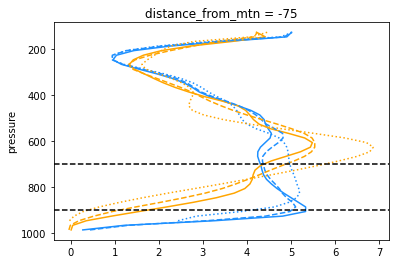

In [86]:
dsdz_sp[:,3000].plot(y='pressure',yincrease=False, label='moist' ,color='dodgerblue')
drydsdz_sp[:,3000].plot(y='pressure',yincrease=False, label='dry',color='orange')
dsdz_sp[:,1700].plot(y='pressure',yincrease=False, label='moist' ,color='dodgerblue',linestyle='--')
drydsdz_sp[:,1700].plot(y='pressure',yincrease=False, label='dry',color='orange',linestyle='--')
dsdz_sp[:,1660].plot(y='pressure',yincrease=False, label='moist' ,color='dodgerblue',linestyle=':')
drydsdz_sp[:,1660].plot(y='pressure',yincrease=False, label='dry',color='orange',linestyle=':')
plt.axhline(700.,color='k',linestyle='--')
plt.axhline(900.,color='k',linestyle='--')

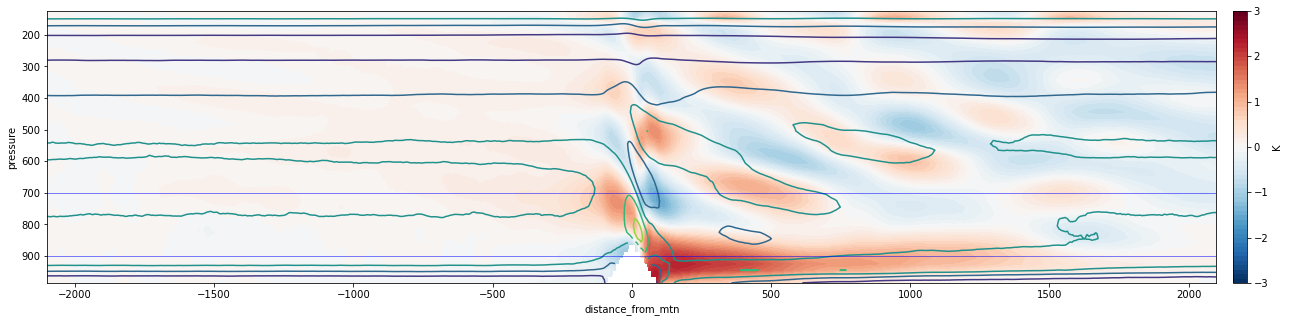

In [109]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
tlevs=np.arange(-3,3.01,0.1)
tticks=np.arange(-3,3.01,1)
((tmean_sp-tmean_sp[:,2200:2400].mean('distance_from_mtn'))-(drytmean_sp-drytmean_sp[:,2200:2400].mean('distance_from_mtn'))).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})
ax.set_xlim(-2100,2100)
(dsdz_sp).plot.contour(ax=ax,y='pressure',yincrease=False)
#(dsdz_sp-drydsdz_sp).plot.contour(ax=ax,y='pressure',yincrease=False,levels=[-1,0,1],colors=['k','k','k'],linestyles=['--','-',':'])
#ax.axvline(-200,color='k',linewidth=0.5)
ax.axhline(700,color='b',linewidth=0.5)
ax.axhline(900,color='b',linewidth=0.5)

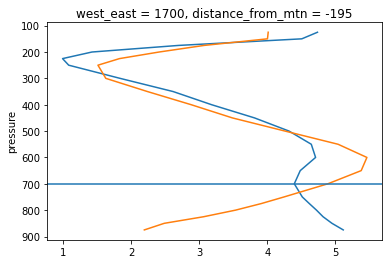

In [49]:
dsdz[:,1700].plot(y='pressure',yincrease=False, label='moist')
drydsdz[:,1700].plot(y='pressure',yincrease=False, label='dry')
plt.axhline(700.)

In [32]:
intdx_dryomegamean_p = np.cumsum(dryomegamean_p[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
intdx_dryomegamean_p=intdx_dryomegamean_p-intdx_dryomegamean_p.sel(distance_from_mtn=-2202)
U=10 #m/s
drydeltatmean_p_theory = -intdx_dryomegamean_p*drydsdp.sel(distance_from_mtn=-2202)/U/cp

In [112]:
intdx_omegamean_p = np.cumsum(omegamean_p[:,::-1],axis=1)[:,::-1]*3000 #(m^2/s)
intdx_omegamean_p=intdx_omegamean_p-intdx_omegamean_p.sel(distance_from_mtn=-2202)
U=10 #m/s
deltatmean_p_theory2 = -intdx_omegamean_p*dsdp.sel(distance_from_mtn=-2202)/U/cp

In [39]:
deltatmean_p_theory = -intdx_dryomegamean_p*dsdp.sel(distance_from_mtn=-2202)/U/cp

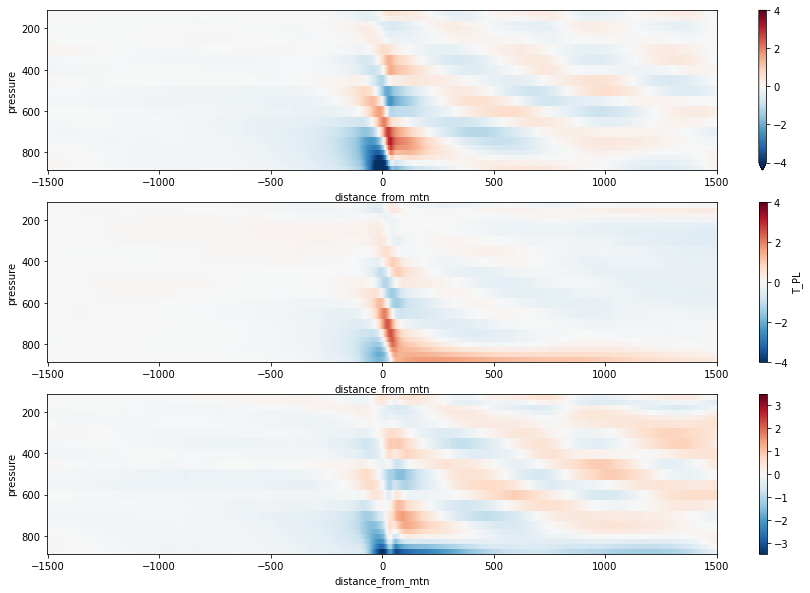

In [47]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
deltatmean_p_theory.sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[0],vmin=-4,vmax=4,yincrease=False,cmap=plt.cm.RdBu_r)
deltatmean_p.sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[1],vmin=-4,vmax=4,yincrease=False,cmap=plt.cm.RdBu_r)
(deltatmean_p_theory -deltatmean_p).sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax[2],yincrease=False,cmap=plt.cm.RdBu_r)#vmin=-1,vmax=1,#;ax.set_title(r"Theory - True | $ds_0/dp$ and $u_0$")


Text(0.5, 1.0, 'Theory - True | $ds_0/dp$ and $u_0$')

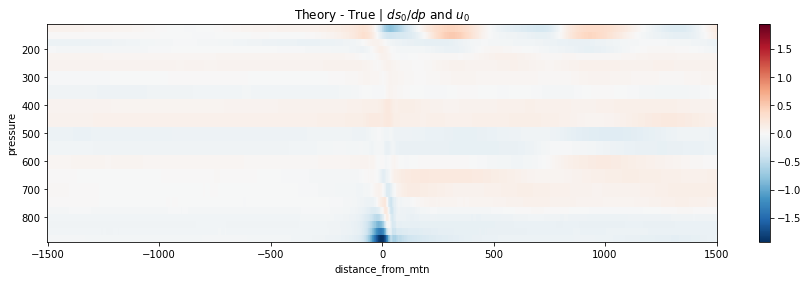

In [45]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
(drydeltatmean_p_theory -drydeltatmean_p).sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax,yincrease=False,cmap=plt.cm.RdBu_r);ax.set_title(r"Theory - True | $ds_0/dp$ and $u_0$")


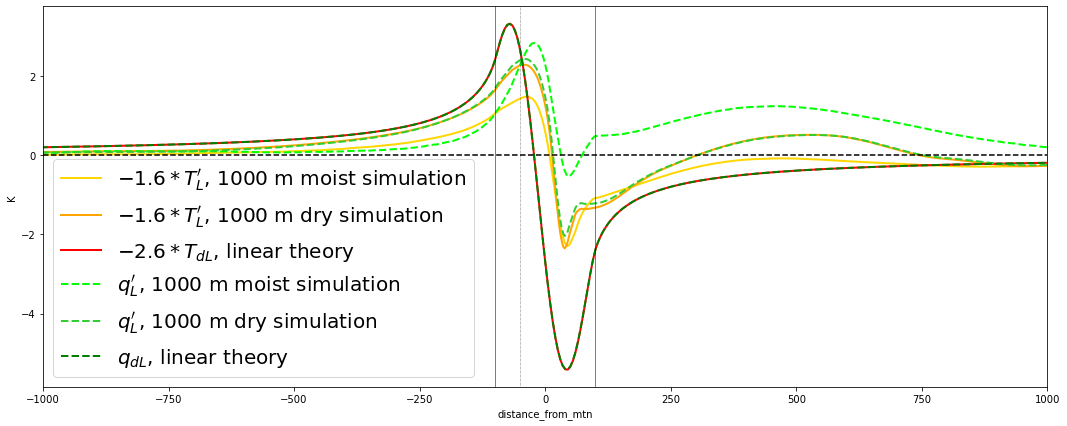

In [29]:
x,Td_hat_linear,qd_hat_linear = linear_Td_qd(10,kind='cos')

fig,ax = plt.subplots(1,1,figsize=(18,7))
lw=2
(-1.6*tmean_p_hat_prime).plot(   ax=ax,color='gold'  ,linewidth=lw,label=r"$-1.6*T_L'$, 1000 m moist simulation")
(-1.6*drytmean_p_hat_prime).plot(ax=ax,color='orange',linewidth=lw,label=r"$-1.6*T_L'$, 1000 m dry simulation")
ax.plot(x/1000,-2.7*Td_hat_linear,   color='red'   ,linewidth=lw,label=r"$-2.6*T_{dL}$, linear theory")

qmean_p_hat_prime.plot(   ax=ax,color='lime'     ,linestyle='--',linewidth=lw,label=r"$q_L'$, 1000 m moist simulation")
dryqmean_p_hat_prime.plot(ax=ax,color='limegreen',linestyle='--',linewidth=lw,label=r"$q_L'$, 1000 m dry simulation")
ax.plot(x/1000,qd_hat_linear,   color='green'    ,linestyle='--',linewidth=lw,label=r"$q_{dL}$, linear theory")

ax.set_xlim(-1000,1000)
ax.set_ylabel("K")
ax.legend(fontsize=20,loc=3)
ax.axhline(0.,linestyle='--',color='k')
ax.axvline(-100.,color='k',linewidth=0.5)
ax.axvline(-50.,color='k',linewidth=0.5,linestyle=':')
ax.axvline(100.,color='k',linewidth=0.5)

# Nonlinear equation

In [81]:
from scipy.integrate import cumtrapz,odeint


def linear_p_theory2(u,kind='gaussian',a=100e3,A=1000,tauT=3,tauq=11,how='nonlinear'):
    xx=np.arange(-10000e3,20000e3,5e3)
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    elif kind=='agnesi':
        hx = A*a**2/(xx**2+a**2)
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P0 = 4. # mm/day
    
    tauT*=3600
    tauq*=3600
    tauqtilde=0.6*tauq
    
    Lq=5*u*tauqtilde
    
    zbot=1000
    ztop=3000
    
    ds0dz = 1004 * 3e-3 # 3K/km
    dq0dz = -2.5e6 * 0.8 *0.022/2500 * 2500/(ztop-zbot) * (np.exp(-zbot/2500)-np.exp(-ztop/2500)) # 0.022 = qsat at 300K, used 80%RH and moisture scale height = 2.5km
    chi = 8000 * (ds0dz/tauT - dq0dz/tauq)/ 2.5e6 * 86400
    N=np.sqrt(9.81/300 * ds0dz/1004.)
    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    wdL = np.array(linear_mountain_wave(hx,N,u,xx,z_slice).mean('z'))
    _,Tdhat,qdhat = linear_Td_qd(10,kind=kind,a=a,A=A)
    Tdhat*=1004/ 2.5e6 * 86400 * 8000
    qdhat*=1004/ 2.5e6 * 86400 * 8000
    def fun(qmhovt,x,how):
        if how=="nonlinear":
            return -1/Lq* (np.maximum(0.,qmhovt+(qdhat/tauq-Tdhat/tauT)[np.argmin((xx-x)**2)])-P0)
        elif how=="linear":
            return -1/Lq* (qmhovt+(qdhat/tauq-Tdhat/tauT)[np.argmin((xx-x)**2)]-P0)
        else:
            raise ValueError("how should be linear or nonlinear")
    qmhovt = odeint(fun,P0,xx,args=(how,))[:,0]
    print(qmhovt.shape)
    return xx,qmhovt,qdhat/tauq-Tdhat/tauT,np.maximum(0.,qmhovt+qdhat/tauq-Tdhat/tauT)
    
    #return xx,wdL
    def fun(p,x):
        return (-((p-P0)/Lq) + wdL[np.argmin((xx-x)**2)]/u*chi)*(p>=0)#*1/(1+np.exp((-p+param2)*param))
    return odeint(fun,P0,xx)

The full equation :
$$\dfrac{\mathrm{d}\langle q_m \rangle}{\mathrm{d}x} + \dfrac{M}{M_s u_0}(\langle Q_c \rangle - \langle Q_0 \rangle) = 0$$
$$\langle Q_c \rangle = \max\left(0,\dfrac{\langle q_m \rangle}{\tilde\tau_q}+\dfrac{q_{dL}}{\tau_q}-\dfrac{T_{dL}}{\tau_T}\right)$$
From there, one can derive an equation for precipitation:
$$\dfrac{\mathrm{d} P}{\mathrm{d}x} + \left[\dfrac{P-P_0}{L_q} - \dfrac{p_s-p_t}{g}\dfrac{\mathrm{d}}{\mathrm{d}x}\left(\dfrac{q_{dL}}{\tau_q}-\dfrac{T_{dL}}{\tau_T}\right)\right]\mathcal{H}(P) = 0$$

Which I had previously mistakenly derived as 
$$\dfrac{\mathrm{d} P}{\mathrm{d}x} +\dfrac{P-P_0}{L_q} - \dfrac{p_s-p_t}{g}\dfrac{\mathrm{d}}{\mathrm{d}x}\left(\dfrac{q_{dL}}{\tau_q}-\dfrac{T_{dL}}{\tau_T}\right) = 0, \text{ then apply the max operator}$$


(0.0, 3.0)

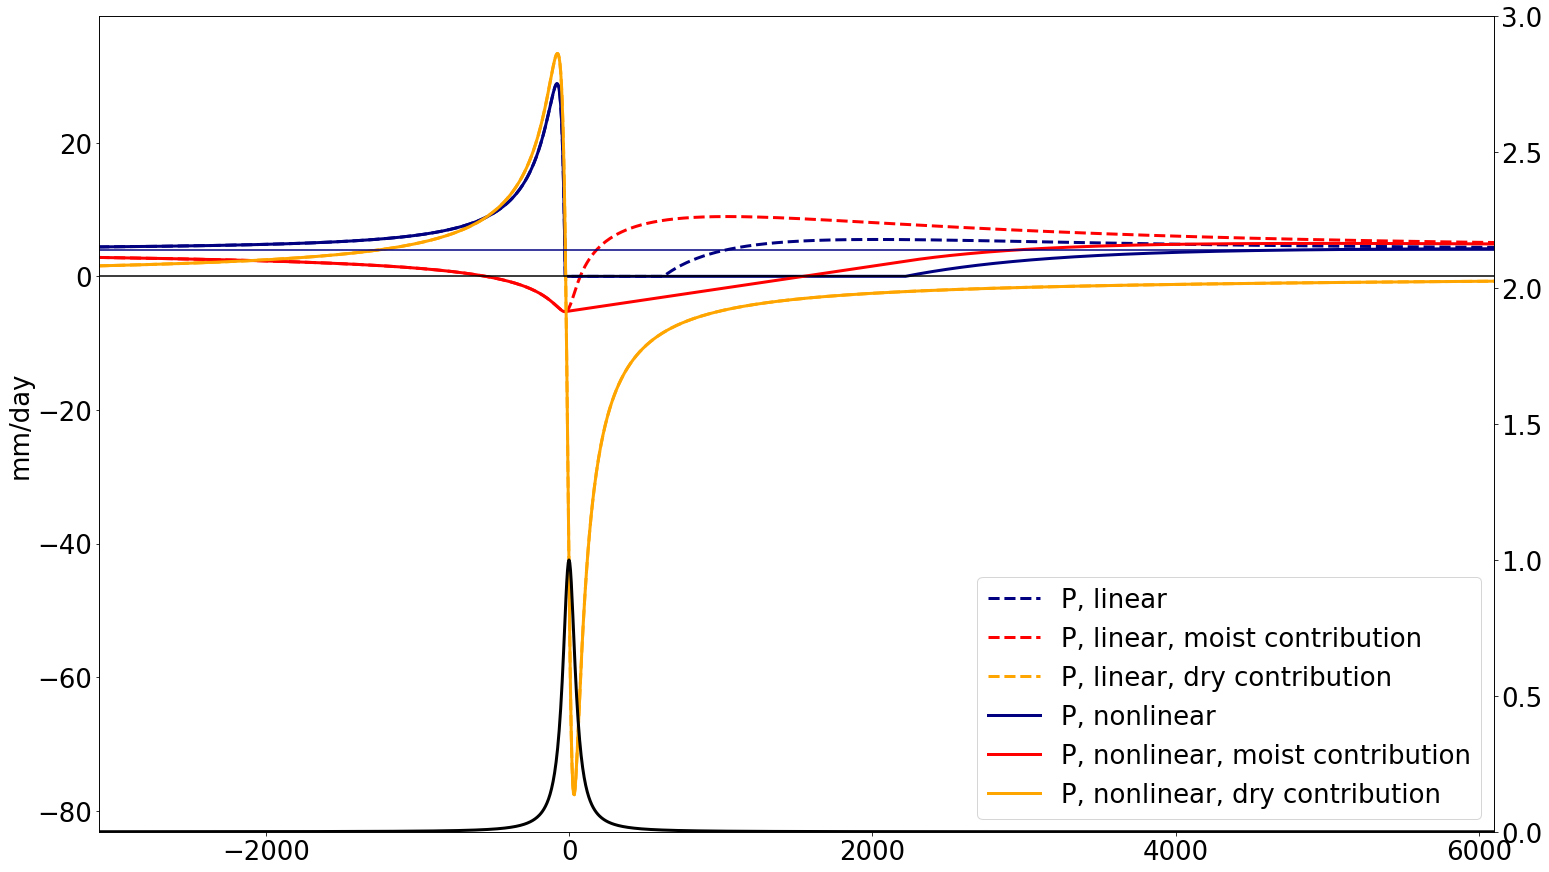

In [33]:
matplotlib.rcParams.update({'font.size': 26})

_,hx,_ = linear_p_theory(10,kind='agnesi',a=50e3,A=1000)
#_,qm,dryP,P1000 = linear_p_theory2(10,kind='agnesi',a=50e3,A=1000,how='linear')
#_,qm_2,dryP_2,P1000_2 = linear_p_theory2(10,kind='agnesi',a=50e3,A=1000)


fig,ax=plt.subplots(1,1,figsize=(25,15))
ax2=ax.twinx()
# precips
ax.plot(x/1000,P1000  ,color='navy'  ,linewidth=3, linestyle='--',label='P, linear')
ax.plot(x/1000,qm     ,color='r'     ,linewidth=3, linestyle='--',label='P, linear, moist contribution')
ax.plot(x/1000,dryP   ,color='orange',linewidth=3, linestyle='--',label='P, linear, dry contribution')
ax.plot(x/1000,P1000_2,color='navy'  ,linewidth=3,label='P, nonlinear')
ax.plot(x/1000,qm_2   ,color='r'     ,linewidth=3,label='P, nonlinear, moist contribution')
ax.plot(x/1000,dryP_2 ,color='orange',linewidth=3,label='P, nonlinear, dry contribution')
#ax.plot(x/1000,P1000_3,color='orange',linewidth=3)
#ax.plot(x/1000,P1000_4,color='b',linewidth=3)

ax.axhline(4.,color='navy')
ax.axhline(0.,color='k')

ax.set_xlim(-3.1e3,6.1e3)
ax.set_ylabel("mm/day")

ax.legend()

# mountain
ax2.plot(x/1000,hx/1000,label=r"$h(x)/h_0$",color='k',linewidth=3)
ax2.set_ylim(0,3)
